# **Installs**

In [ ]:
!pip install photutils --quiet
!pip install webbpsf --quiet

In [ ]:
!wget https://stsci.box.com/shared/static/qxpiaxsjwo15ml6m4pkhtk36c9jgj70k.gz -O webbpsf-data-1.2.1.tar.gz

In [ ]:
!tar -xf webbpsf-data-1.2.1.tar.gz

In [ ]:
!rm webbpsf-data-1.2.1.tar.gz

In [ ]:
!pip uninstall numexpr --quiet -y

# **Imports**

In [2]:
import sys
import time
import numpy as np
import pandas as pd
import glob as glob
import urllib.request
import tarfile
import os
import itertools

from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d

from astropy.io import fits
from astropy.visualization import simple_norm
from astropy.nddata import NDData
from astropy.wcs import WCS
from astropy.modeling import models, fitting
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.table import Table, QTable, vstack
from astropy.coordinates import SkyCoord, match_coordinates_sky, angular_separation
from astropy import units as u
from astropy.stats import SigmaClip, sigma_clipped_stats, gaussian_fwhm_to_sigma
from astropy.convolution import Gaussian2DKernel, convolve_fft
from astropy.nddata.utils import Cutout2D

import photutils as phot
from photutils.background import MMMBackground, MADStdBackgroundRMS, Background2D, LocalBackground
from photutils.detection import DAOStarFinder
from photutils.psf import EPSFBuilder, GriddedPSFModel
from photutils.psf import SourceGrouper, extract_stars, IterativePSFPhotometry, DAOPhotPSFPhotometry

from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry, EllipticalAperture

from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde
from scipy.ndimage import sobel, gaussian_filter, convolve
from scipy.signal import savgol_filter

In [3]:
from reproject import reproject_exact
from reproject.mosaicking import find_optimal_celestial_wcs

In [4]:
os.environ['WEBBPSF_PATH'] = '../data/webbpsf-data'

In [48]:
%matplotlib inline
from matplotlib import style, pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import matplotlib.colors as col
from matplotlib.colors import ListedColormap
from matplotlib.patches import Circle
import seaborn as sb
import matplotlib.gridspec as gridspec
sb.set_style('white')
from matplotlib.ticker import (MultipleLocator, AutoLocator, AutoMinorLocator)
from matplotlib.patches import Rectangle

from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['figure.figsize'] = (7,5)
plt.rcParams['axes.titlesize'] = plt.rcParams['axes.labelsize'] = 25
plt.rcParams['xtick.labelsize'] = plt.rcParams['ytick.labelsize'] = 25

font1 = {'family': 'sans-serif', 'color': 'black', 'weight': 'normal', 'size': '15'}
font2 = {'family': 'sans-serif', 'color': 'black', 'weight': 'normal', 'size': '25'}

In [6]:
import webbpsf
from webbpsf.utils import to_griddedpsfmodel

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-062 CANNOT BE CHECKED AGAINST ONLINE VERSION


In [7]:
import pista as pt
from pista.utils import Xmatch
data_path = pt.data_dir

In [8]:
""" Simulated (Webb PSF)
filters = ['F070W', 'F090W', 'F115W', 'F140M', 'F150W2','F150W', 'F162M', 'F164N', 'F182M',
           'F187N', 'F200W', 'F210M', 'F212N', 'F250M', 'F277W', 'F300M', 'F322W2','F323N',
           'F335M', 'F356W', 'F360M', 'F405N', 'F410M', 'F430M', 'F444W', 'F460M', 'F466N', 'F470N', 'F480M']

psf_fwhm = [0.987,   1.103,   1.298,   1.553,   1.628,   1.770,   1.801,   1.494,   1.990, 
            2.060,   2.141,   2.304,   2.341,   1.340,   1.444,   1.585,   1.547,   1.711, 
            1.760,   1.830,   1.901,   2.165,   2.179,   2.300,   2.302,   2.459,   2.507, 2.535, 2.574]

dict_utils = {filters[i]: {'psf fwhm': psf_fwhm[i]} for i in range(len(filters))}
""";

In [9]:
# Empirical (Rigby et al. 2022). https://jwst-docs.stsci.edu/jwst-near-infrared-camera/nircam-performance/nircam-point-spread-functions
filters = ['F070W', 'F090W', 'F115W', 'F140M', 'F150W2','F150W', 'F162M', 'F164N', 'F182M',
           'F187N', 'F200W', 'F210M', 'F212N', 'F250M', 'F277W', 'F300M', 'F322W2','F323N',
           'F335M', 'F356W', 'F360M', 'F405N', 'F410M', 'F430M', 'F444W', 'F460M', 'F466N', 'F470N', 'F480M']

psf_fwhm = [0.935,   1.065,   1.290,   1.548,   1.628,   1.613,   1.774,   1.806,   2.000, 
            2.065,   2.129,   2.290,   2.323,   1.349,   1.460,   1.587,   1.547,   1.714, 
            1.762,   1.841,   1.905,   2.159,   2.175,   2.286,   2.302,   2.492,   2.508, 2.540, 2.603]

dict_utils = {filters[i]: {'psf fwhm': psf_fwhm[i]} for i in range(len(filters))}

# **Synthetic PSF using Webb PSF**

In [8]:
psfs_dir = 'PSF_MODELS/'

if not os.path.exists(psfs_dir):
    os.makedirs(psfs_dir)

def create_psf_model(det='NRCA1', filt='F770W', fov=101, source=None,
                     create_grid=False, num=9, save_psf=False,
                     detsampled=False,all_detectors=False,oversample=5):

    nrc = webbpsf.NIRCam()

    nrc.detector = det
    nrc.filter = filt

    print("Using a {field}".format(field=fov), "px fov")

    if create_grid:
        print("")
        print("Creating a grid of PSF for filter {filt} and detector {det}".format(filt=filt, det=det))
        print("")
        num = num

        if save_psf:

            outname = 'PSF_%s_samp%s_fov%d_npsfs%d.fits' % (filt,oversample, fov, num)
            psf = nrc.psf_grid(num_psfs=num, oversample=oversample, source=source, all_detectors=all_detectors,fov_pixels=fov,
                               save=True, outfile=os.path.join(psfs_dir,outname), use_detsampled_psf=detsampled)

        else:

            psf = nrc.psf_grid(num_psfs=num, oversample=oversample, source=source, all_detectors=all_detectors, fov_pixels=fov,
                               use_detsampled_psf=detsampled)

    else:
        print("")
        print("Creating a single PSF for filter {filt} and detector {det}".format(filt=filt, det=det))
        print("")
        num = 1

        if save_psf:

            outname = 'PSF_%s_samp%s_fov%d_npsfs%d.fits' % (filt, oversample, fov, num)
            psf = nrc.psf_grid(num_psfs=num, oversample=oversample, source=source, all_detectors=False, fov_pixels=fov,
                               save=True, outfile=os.path.join(psfs_dir,outname), use_detsampled_psf=detsampled)

        else:

            psf = nrc.psf_grid(num_psfs=num, oversample=oversample, source=source, all_detectors=False, fov_pixels=fov,
                               use_detsampled_psf=detsampled)

    return psf

# **Empirical PSF**

In this section we explore how to construct an empirical PSF from the data using Astropy and Photutils

## **Source Detection**

As a first step to empirical PSF construction we select the stars using which we will be constructing the PSF. We use Photutils Backgound2D for estimating the background and create background subtracted image for employing DAOStarFinder for detecting sources.

In [10]:
def calc_bkg(data, sigma=3.0, box_size=(100,100), filter_size=(3,3)):

    bkgrms = MADStdBackgroundRMS()
    mmm_bkg = MMMBackground()

    #sigma_clip = SigmaClip(sigma=sigma)
    sigma_clip = SigmaClip(sigma=sigma)
    coverage_mask = (data == 0)

    bkg = Background2D(data, box_size, filter_size=filter_size,
                       sigma_clip=sigma_clip, bkg_estimator=mmm_bkg,
                        coverage_mask=coverage_mask, fill_value=0.0)

    data_bkgsub = data.copy()
    data_bkgsub = data_bkgsub - bkg.background

    _, _, std = sigma_clipped_stats(data_bkgsub)

    return data_bkgsub, bkg, std

In [ ]:
def find_stars(data, det='NRCA1', filt='F070W', threshold=3, sigma=3.0, sigma_psf=None, smoothen=True, kernel=None,ZP=0):

    if sigma_psf is None:
        sigma_psf = dict_utils[filt]['psf fwhm']

    if smoothen and kernel is not None:
        data = convolve_fft(data, kernel)

    data_bkgsub, bkg, std = calc_bkg(data, sigma)

    daofind = DAOStarFinder(threshold=threshold*std, fwhm=sigma_psf)
    found_stars = daofind(data_bkgsub)
    found_stars['mag'] = ZP + found_stars['mag']

    print('\nNumber of sources found in the image:', len(found_stars))
    print('-------------------------------------\n')

    return found_stars, data_bkgsub,bkg

## **Source Selection**

In this section we select the sources for empirical PSF construction. We want sources which are sufficiently round, sharp and bright. Thus, we apply roundness, sharpness and magnitude cuts based on thier distribuitions.

In [ ]:
def select_stars(found_stars, mag_inf, mag_up,round_inf=-0.4, round_sup=0.4, sh_inf=0.78, sh_sup=0.92, min_sep=10):

    mask = ((found_stars['mag'] > mag_inf) & (found_stars['mag'] < mag_up) & (found_stars['roundness2'] > round_inf)
            & (found_stars['roundness2'] < round_sup) & (found_stars['sharpness'] > sh_inf)
            & (found_stars['sharpness'] < sh_sup))

    found_stars_sel = found_stars[mask]
    found_stars_sel_f115w = found_stars_sel

    print('Number of stars selected to build ePSF:', len(found_stars_sel))

    # if we include the separation criteria:

    d = []

    x_tot = found_stars['xcentroid']
    y_tot = found_stars['ycentroid']

    for xx, yy in zip(found_stars_sel['xcentroid'], found_stars_sel['ycentroid']):

        sep = []
        dist = np.sqrt((x_tot - xx)**2 + (y_tot - yy)**2)
        sep = np.sort(dist)[1:2][0]
        d.append(sep)

    found_stars_sel['min distance'] = d
    mask_dist = (found_stars_sel['min distance'] > min_sep)

    found_stars_sel2 = found_stars_sel[mask_dist]

    print('Number of stars selected to build ePSF \
    \nincluding "mimimum distance closest neighbour" selection):', len(found_stars_sel2))

    return found_stars_sel2

In [ ]:
def build_epsf(data, det='NRCA1', filt='F070W', size=11, found_table=None, oversample=4, iters=10):

    hsize = size

    x = found_table['xcentroid']
    y = found_table['ycentroid']

    mask = ((x > hsize) & (x < (data.shape[1] - 1 - hsize)) & (y > hsize) & (y < (data.shape[0] - 1 - hsize)))

    stars_tbl = Table()
    stars_tbl['x'] = x[mask]
    stars_tbl['y'] = y[mask]

    nddata = NDData(data=data)
    stars = extract_stars(nddata, stars_tbl, size=size)

    print('Creating ePSF --- Detector {d}, filter {f}'.format(f=filt, d=det))

    epsf_builder = EPSFBuilder(oversampling=oversample, maxiters=iters, progress_bar=True)

    epsf, fitted_stars = epsf_builder(stars)

    return epsf,stars

# **PSF Photometry using Photutils**

In [ ]:
output_phot_dir = './PHOT_OUTPUT/'

if not os.path.exists(output_phot_dir):
    os.makedirs(output_phot_dir)

res_dir = './RESIDUAL_IMAGES/'

if not os.path.exists(res_dir):
    os.makedirs(res_dir)

def psf_phot(data=None, det='NRCA1', filt='F070W', th=2000,
             fit_shape=(11,11),
             sub_shape=(11,11),
             psf=None, ap_radius=5, 
             save_residuals=False,
             header=None,
             save_output=False,
             maxiters=2,min_sep=5,
             ZP=0,
             save_bkg=False):

    fitter = LevMarLSQFitter()
    sigma_clip = SigmaClip(sigma_lower=2.25, sigma_upper=2.00)
    bkgstat = MMMBackground(sigma_clip=sigma_clip)
    localbkg_estimator = LocalBackground(15, 35, bkgstat)

    fwhm_psf = dict_utils[filt]['psf fwhm']
    print('FWHM for filter {f}:'.format(f=filt), fwhm_psf)

    data_bkgsub, bkg, std = calc_bkg(data)

    daofind = DAOStarFinder(threshold=th*std, fwhm=fwhm_psf)

    grouper = SourceGrouper(min_sep*fwhm_psf)

    psf_model = psf.copy()

    print('Performing the PSF photometry --- Detector {d}, filter {f}'.format(f=filt, d=det))
    
    tic = time.perf_counter()

    phot = IterativePSFPhotometry(finder=daofind, grouper=grouper,
                                  localbkg_estimator=localbkg_estimator,
                                  psf_model=psf_model,fitter=fitter,
                                  maxiters=maxiters, fit_shape=fit_shape,
                                  aperture_radius=ap_radius,
                                  sub_shape=sub_shape,
                                  progress_bar=True)
    
    
    result = phot(data_bkgsub)

    toc = time.perf_counter()

    print('Time needed to perform photometry:', '%.2f' % ((toc - tic) / 3600), 'hours')
    print('Number of sources detected:', len(result))

    residual_image = phot.make_residual_image(data_bkgsub, sub_shape)

    # save the residual images as fits file:

    if save_residuals:
        hdu = fits.PrimaryHDU(residual_image, header)
        hdul = fits.HDUList([hdu])

        residual_outname = 'residual_%s_%s.fits' % (det, filt)
        hdul.writeto(os.path.join(res_dir, residual_outname), overwrite=True)


    if save_bkg:
        hdu = fits.PrimaryHDU(bkg.background,header)
        hdul = fits.HDUList([hdu])

        bkg_outname = 'background_%s_%s.fits' % (det, filt)
        hdul.writeto(os.path.join(res_dir, bkg_outname), overwrite=True)

    # save the output photometry Tables

    if save_output:

        outname = 'phot_%s_%s.pkl' % (det, filt)

        tab = result.to_pandas()
        tab.to_pickle(os.path.join(output_phot_dir, outname))

    result['mag'] = ZP -2.5*np.log10(result['flux_fit'])
    result['mag_err'] = 2.5/np.log(10)*result['flux_err']/result['flux_fit']

    return result, residual_image, phot, bkg

# **Pipeline**

## **Input Data**

In [10]:
region = 'center'

if region=='bubble':
    ra, dec = 24.1859050, 15.7726111
if region=='bkg1':
    ra, dec = 24.1918038, 15.7600032
elif region=='bkg2':
    ra, dec = 24.1787197, 15.7543227
elif region=='bkg3':
    ra, dec = 24.1728133, 15.7669357
elif region=='epsf':
    ra, dec = 24.2006271, 15.7515889
elif region=='center':
    ra, dec = 24.1738983, 15.7836543

### **JWST**

In [11]:
dict_images = {'NRCA1': {}, 'NRCA2': {}, 'NRCA3': {}, 'NRCA4': {}, 'NRCA5': {},
               'NRCB1': {}, 'NRCB2': {}, 'NRCB3': {}, 'NRCB4': {}, 'NRCB5': {}}

dict_cats = {}

images_dir = '../data/NGC_628/JWST/'

images = sorted(glob.glob(os.path.join(images_dir, "*/*i2d.fits")))
cats  = sorted(glob.glob(os.path.join(images_dir, "*/*cat.ecsv")))

for image in images:

    im = fits.open(image)
    f = im[0].header['FILTER']
    d = im[0].header['DETECTOR']

    if d == 'MULTIPLE':
        d = 'NRCB3'

    # Image
    if d not in dict_images.keys():
        dict_images[d] = {}
        
    if f not in dict_images[d].keys():
        dict_images[d][f] =  {'images': [image]}
    else:
        dict_images[d][f]['images'].append(image)
    
    # Catalog
    if d not in dict_cats.keys():
        dict_cats[d] = {}
        
    if f not in dict_cats[d].keys():
        dict_cats[d][f] =  {'cats': [image[:-8] + 'cat.ecsv']}
    else:
        dict_cats[d][f]['cats'].append(image[:-8] + 'cat.ecsv')
        
 
print('Available Detectors and Filters\n-------------------------------')
      
for i in dict_images.keys():
    if len(dict_images[i])>0:
        print(f'{i} :', list(dict_images[i].keys()))

Available Detectors and Filters
-------------------------------
NRCB3 : ['F115W', 'F150W', 'F187N', 'F200W', 'F277W', 'F335M', 'F444W']
MIRIMAGE : ['F1000W', 'F1130W', 'F2100W', 'F770W']


In [12]:
# MIRI
det_m = 'MIRIMAGE'
filt_m = 'F770W'

hdul_m = fits.open(dict_images[det_m][filt_m]['images'][0])
data_m = hdul_m[1].data
area_m = hdul_m[4].data

imh_m = hdul_m[1].header
wcs_m = WCS(imh_m)
ZAB_m = -6.1 - 2.5*np.log10(imh_m['PIXAR_SR'])
hdul_m.close()
print(f"Flux units of {filt_m}: {imh_m['BUNIT']}, Zero point (AB) : {ZAB_m}")
# NIRCAM
det_n = 'NRCB3'
filt_n = 'F115W'

hdul_n = fits.open(dict_images[det_n][filt_n]['images'][0])
data_n = hdul_n[1].data

imh_n = hdul_n[1].header
wcs_n = WCS(imh_n)
ZAB_n = -6.1 -2.5*np.log10(imh_n['PIXAR_SR'])

print(f"Flux units of {filt_n}: {imh_n['BUNIT']}, Zero point (AB) : {ZAB_n}")
hdul_n.close()

Flux units of F770W: MJy/sr, Zero point (AB) : 25.265162240091172
Flux units of F115W: MJy/sr, Zero point (AB) : 28.012472935440215


Set DATE-AVG to '2022-07-17T12:01:53.586' from MJD-AVG.
Set DATE-END to '2022-07-17T12:54:46.016' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -37.750319 from OBSGEO-[XYZ].
Set OBSGEO-H to 1738818645.548 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-07-29T07:50:56.201' from MJD-AVG.
Set DATE-END to '2022-07-29T09:11:42.893' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -35.423659 from OBSGEO-[XYZ].
Set OBSGEO-H to 1708322100.317 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [12]:
"""
wcs_new = wcs_m.deepcopy()

wcs_new.wcs.pc= [[-1,0],
                 [0,1]]
wcs_new.wcs.crpix = np.array([750,750])
wcs_new.wcs.crval= np.array([24.173953, 15.783691])

out, footprint= reproject_exact((data_m, wcs_m), wcs_new, (1500,1500))
""";

In [13]:
"""
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection=wcs_new)

norm = simple_norm(out, log_a=100, stretch= 'log',min_cut=12.6, max_cut = 65)

img = ax.imshow(out, norm = norm , cmap='gray')
cb = plt.colorbar(img, shrink=0.75, orientation='horizontal', pad=0.09)
cb.set_label('MJy/Sr')
cb.ax.tick_params(labelsize=20)


pos_bub = wcs_new.world_to_pixel_values([[24.186079, 15.772189]])
pos_gal = wcs_new.world_to_pixel_values([[24.173953, 15.783691]])

aper_in = EllipticalAperture(pos_bub, 162.26, 127.11, 216*u.degree)
aper_out = EllipticalAperture(pos_bub, 90.15, 70.62, 216*u.degree)

aper_in.plot(ax)
aper_out.plot(ax)

ax.annotate('', xy=pos_bub[0],
             xycoords='data',
             xytext=pos_gal[0],
             textcoords='data',
             arrowprops=dict(arrowstyle= '<|-|>',
                             color='white',
                             lw=1.5,
                             ls='-')
           )

ax.text(450,502,"1'=2.8kpc",rotation=46, color='white', fontsize=20)

ax.xaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=7,direction="in")
ax.tick_params(which='minor', length=4)

lon = ax.coords[0]
lat = ax.coords[1]

lon.display_minor_ticks(True)
lat.display_minor_ticks(True)
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
""";

In [14]:
"""
plt.figure(figsize=(20, 12))

ax1= plt.subplot(1, 2, 1, projection=wcs_m)

ax1.set_title(filt_m, fontdict=font2)
norm = simple_norm(data_m, 'sqrt',min_cut=12, max_cut = 40)

img = ax1.imshow(data_m, norm = norm, cmap='gray')
ax1.grid(color='red', ls='solid')
cb = plt.colorbar(img, orientation='horizontal', anchor = (0.5, 1.5))
cb.set_label(f"{imh_m['BUNIT']}")

ax2 = plt.subplot(1, 2, 2, projection=wcs_n)

ax2.set_title(filt_n, fontdict=font2)
norm = simple_norm(data_n, 'sqrt',percent=99.)


img = ax2.imshow(data_n, norm = norm, cmap='gray')
ax2.grid(color='red', ls='solid')
cb = plt.colorbar(img, orientation='horizontal', anchor = (0.5, 1.5))
cb.set_label(f"{imh_n['BUNIT']}")
""";

### **Photometry strategy**

#### **Full FoV**

In [15]:
np.array(data_n.shape)

array([ 4486, 11417])

In [17]:
y = np.arange(0, 4486 + 1275, 1275)
x = np.arange(0, 11417 + 1275, 1275)

x_cen = 0.5*(x[:-1] + x[1:])
y_cen = 0.5*(y[:-1] + y[1:])

In [18]:
11420/10, 4490/5

(1142.0, 898.0)

In [19]:
poss = []
for i in x_cen:
    for j in y_cen:
        poss.append([i,j-318.75])
        
poss = np.array(poss)

(0.0, 4486.0)

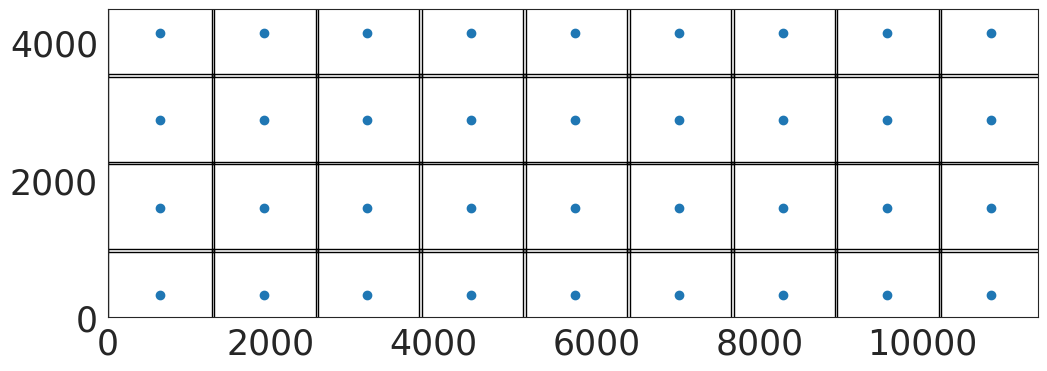

In [20]:
x = poss[:,0]
y = poss[:,1]
fig, ax = plt.subplots(figsize=(12,4))
ax.scatter(x,y)

for i,j in poss:
        ax.add_patch(Rectangle((i-637.5, j-637.5), 1307,1307, fill = False,
                              edgecolor='black', lw=1))


ax.set_xlim(0,11417)
ax.set_ylim(0,4486)

In [23]:
coords = np.array(wcs_n.pixel_to_world_values(poss))

box(24.1709481, 15.8310479, 40.5",40.5",245.74936) # text={Reg 0}
box(24.1604202, 15.8264846, 40.5",40.5",245.74936) # text={Reg 1}
box(24.1498928, 15.8219209, 40.5",40.5",245.74936) # text={Reg 2}
box(24.1393658, 15.8173566, 40.5",40.5",245.74936) # text={Reg 3}
box(24.1756908, 15.820919, 40.5",40.5",245.74936) # text={Reg 4}
box(24.1651633, 15.816356, 40.5",40.5",245.74936) # text={Reg 5}
box(24.1546363, 15.8117924, 40.5",40.5",245.74936) # text={Reg 6}
box(24.1441097, 15.8072284, 40.5",40.5",245.74936) # text={Reg 7}
box(24.180433, 15.81079, 40.5",40.5",245.74936) # text={Reg 8}
box(24.1699059, 15.8062272, 40.5",40.5",245.74936) # text={Reg 9}
box(24.1593793, 15.8016639, 40.5",40.5",245.74936) # text={Reg 10}
box(24.1488532, 15.7971001, 40.5",40.5",245.74936) # text={Reg 11}
box(24.1851748, 15.8006609, 40.5",40.5",245.74936) # text={Reg 12}
box(24.1746481, 15.7960983, 40.5",40.5",245.74936) # text={Reg 13}
box(24.1641219, 15.7915352, 40.5",40.5",245.74936) # text={Reg 14}
box(24.153

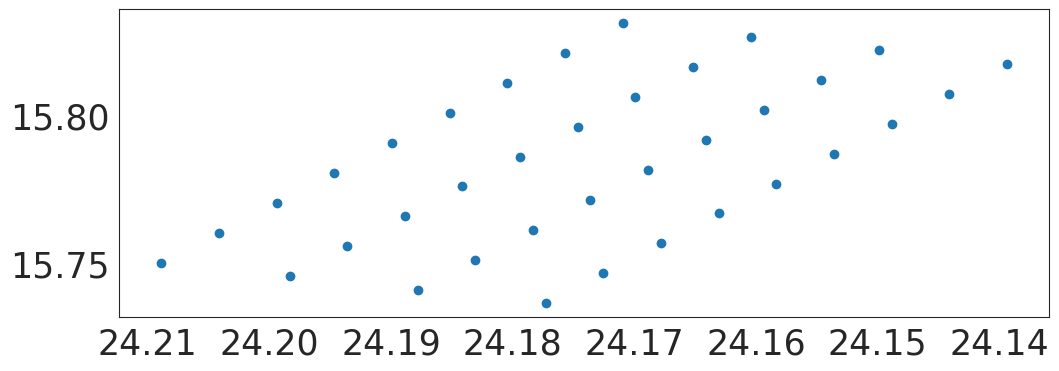

In [24]:
x = coords[:,0]
y = coords[:,1]
fig, ax = plt.subplots(figsize=(12,4))
ax.scatter(x,y)

regions = {}
for n,coord in enumerate(coords):
    i = coord[0]
    j = coord[1]
    regions[f'reg_{n}'] = {}
    regions[f'reg_{n}']['ra'] = i
    regions[f'reg_{n}']['dec'] = j
    print(f"""box({np.round(i,7)}, {np.round(j,7)}, 40.5",40.5",245.74936) # text=""" + '{' + f'Reg {n}' + '}')
    
ax.invert_xaxis()

In [13]:
regions;

NameError: name 'regions' is not defined

In [17]:
y = np.arange(0, 4486 + 1275, 1275)
x = np.arange(0, 11417 + 1275, 1275)

x_cen = 0.5*(x[:-1] + x[1:])
y_cen = 0.5*(y[:-1] + y[1:])

In [18]:
11420/10, 4490/5

(1142.0, 898.0)

In [19]:
poss = []
for i in x_cen:
    for j in y_cen:
        poss.append([i,j-318.75])
        
poss = np.array(poss)

(0.0, 4486.0)

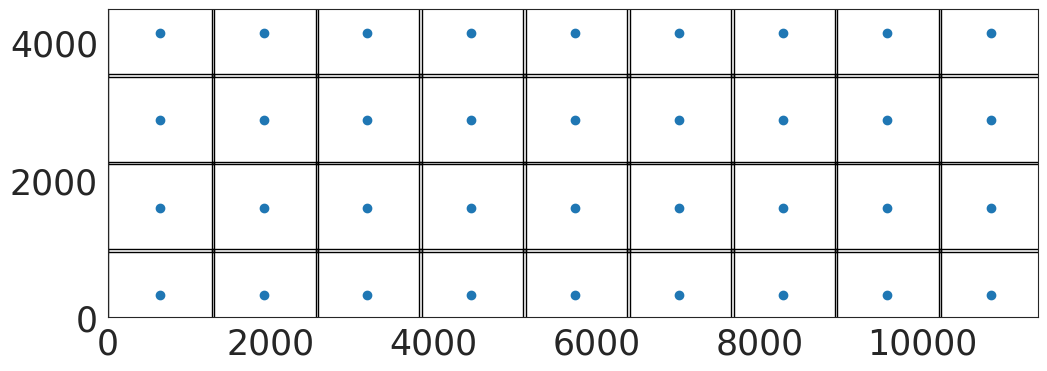

In [20]:
x = poss[:,0]
y = poss[:,1]
fig, ax = plt.subplots(figsize=(12,4))
ax.scatter(x,y)

for i,j in poss:
        ax.add_patch(Rectangle((i-637.5, j-637.5), 1307,1307, fill = False,
                              edgecolor='black', lw=1))


ax.set_xlim(0,11417)
ax.set_ylim(0,4486)

In [23]:
coords = np.array(wcs_n.pixel_to_world_values(poss))

box(24.1709481, 15.8310479, 40.5",40.5",245.74936) # text={Reg 0}
box(24.1604202, 15.8264846, 40.5",40.5",245.74936) # text={Reg 1}
box(24.1498928, 15.8219209, 40.5",40.5",245.74936) # text={Reg 2}
box(24.1393658, 15.8173566, 40.5",40.5",245.74936) # text={Reg 3}
box(24.1756908, 15.820919, 40.5",40.5",245.74936) # text={Reg 4}
box(24.1651633, 15.816356, 40.5",40.5",245.74936) # text={Reg 5}
box(24.1546363, 15.8117924, 40.5",40.5",245.74936) # text={Reg 6}
box(24.1441097, 15.8072284, 40.5",40.5",245.74936) # text={Reg 7}
box(24.180433, 15.81079, 40.5",40.5",245.74936) # text={Reg 8}
box(24.1699059, 15.8062272, 40.5",40.5",245.74936) # text={Reg 9}
box(24.1593793, 15.8016639, 40.5",40.5",245.74936) # text={Reg 10}
box(24.1488532, 15.7971001, 40.5",40.5",245.74936) # text={Reg 11}
box(24.1851748, 15.8006609, 40.5",40.5",245.74936) # text={Reg 12}
box(24.1746481, 15.7960983, 40.5",40.5",245.74936) # text={Reg 13}
box(24.1641219, 15.7915352, 40.5",40.5",245.74936) # text={Reg 14}
box(24.153

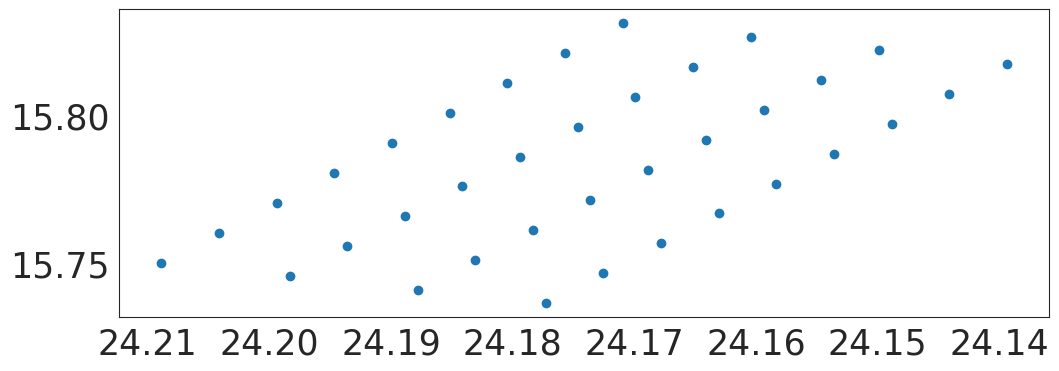

In [24]:
x = coords[:,0]
y = coords[:,1]
fig, ax = plt.subplots(figsize=(12,4))
ax.scatter(x,y)

regions = {}
for n,coord in enumerate(coords):
    i = coord[0]
    j = coord[1]
    regions[f'reg_{n}'] = {}
    regions[f'reg_{n}']['ra'] = i
    regions[f'reg_{n}']['dec'] = j
    print(f"""box({np.round(i,7)}, {np.round(j,7)}, 40.5",40.5",245.74936) # text=""" + '{' + f'Reg {n}' + '}')
    
ax.invert_xaxis()

In [13]:
regions;

NameError: name 'regions' is not defined

#### **Radial Completeness**

In [30]:
poss_cen = wcs_n.world_to_pixel_values([[ra,dec]])[0]

In [36]:
poss_cen[0]

5730.6598113845575

In [45]:
poss = []
for i in range(5):
    poss.append([poss_cen[0]+1307.*i,poss_cen[1]])

poss = np.array(poss)

In [46]:
1307/2

653.5

(0.0, 4486.0)

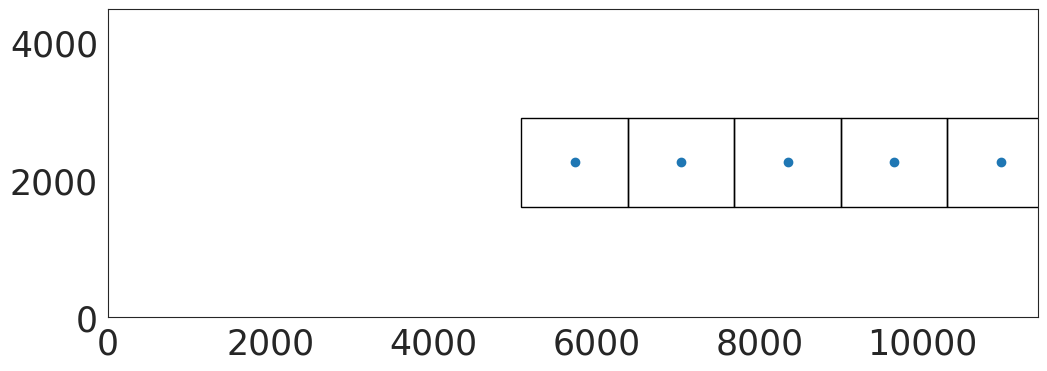

In [49]:
x = poss[:,0]
y = poss[:,1]
fig, ax = plt.subplots(figsize=(12,4))
ax.scatter(x,y)

for i,j in poss:
        ax.add_patch(Rectangle((i-653.5, j-653.5), 1307,1307, fill = False,
                              edgecolor='black', lw=1))


ax.set_xlim(0,11417)
ax.set_ylim(0,4486)

In [50]:
coords = np.array(wcs_n.pixel_to_world_values(poss))

In [51]:
regions = {}
for n,coord in enumerate(coords):
    i = coord[0]
    j = coord[1]
    regions[f'reg_{n}'] = {}
    regions[f'reg_{n}']['ra'] = i
    regions[f'reg_{n}']['dec'] = j

In [52]:
regions

{'reg_0': {'ra': 24.1738983, 'dec': 15.783654299999997},
 'reg_1': {'ra': 24.178758715702823, 'dec': 15.773271121955174},
 'reg_2': {'ra': 24.183618633437526, 'dec': 15.762887836899594},
 'reg_3': {'ra': 24.188478053210716, 'dec': 15.752504445739396},
 'reg_4': {'ra': 24.193336975029013, 'dec': 15.742120949380759}}

### **Plots**

In [14]:
pos = SkyCoord(ra=ra, dec=dec, unit='deg')

In [15]:
cutout_m = Cutout2D(data_m,pos,size = 41*u.arcsec, wcs = wcs_m)
cutout_n = Cutout2D(data_n,pos,size = 41*u.arcsec, wcs = wcs_n)

In [16]:
cutout_n.data.shape

(1307, 1307)

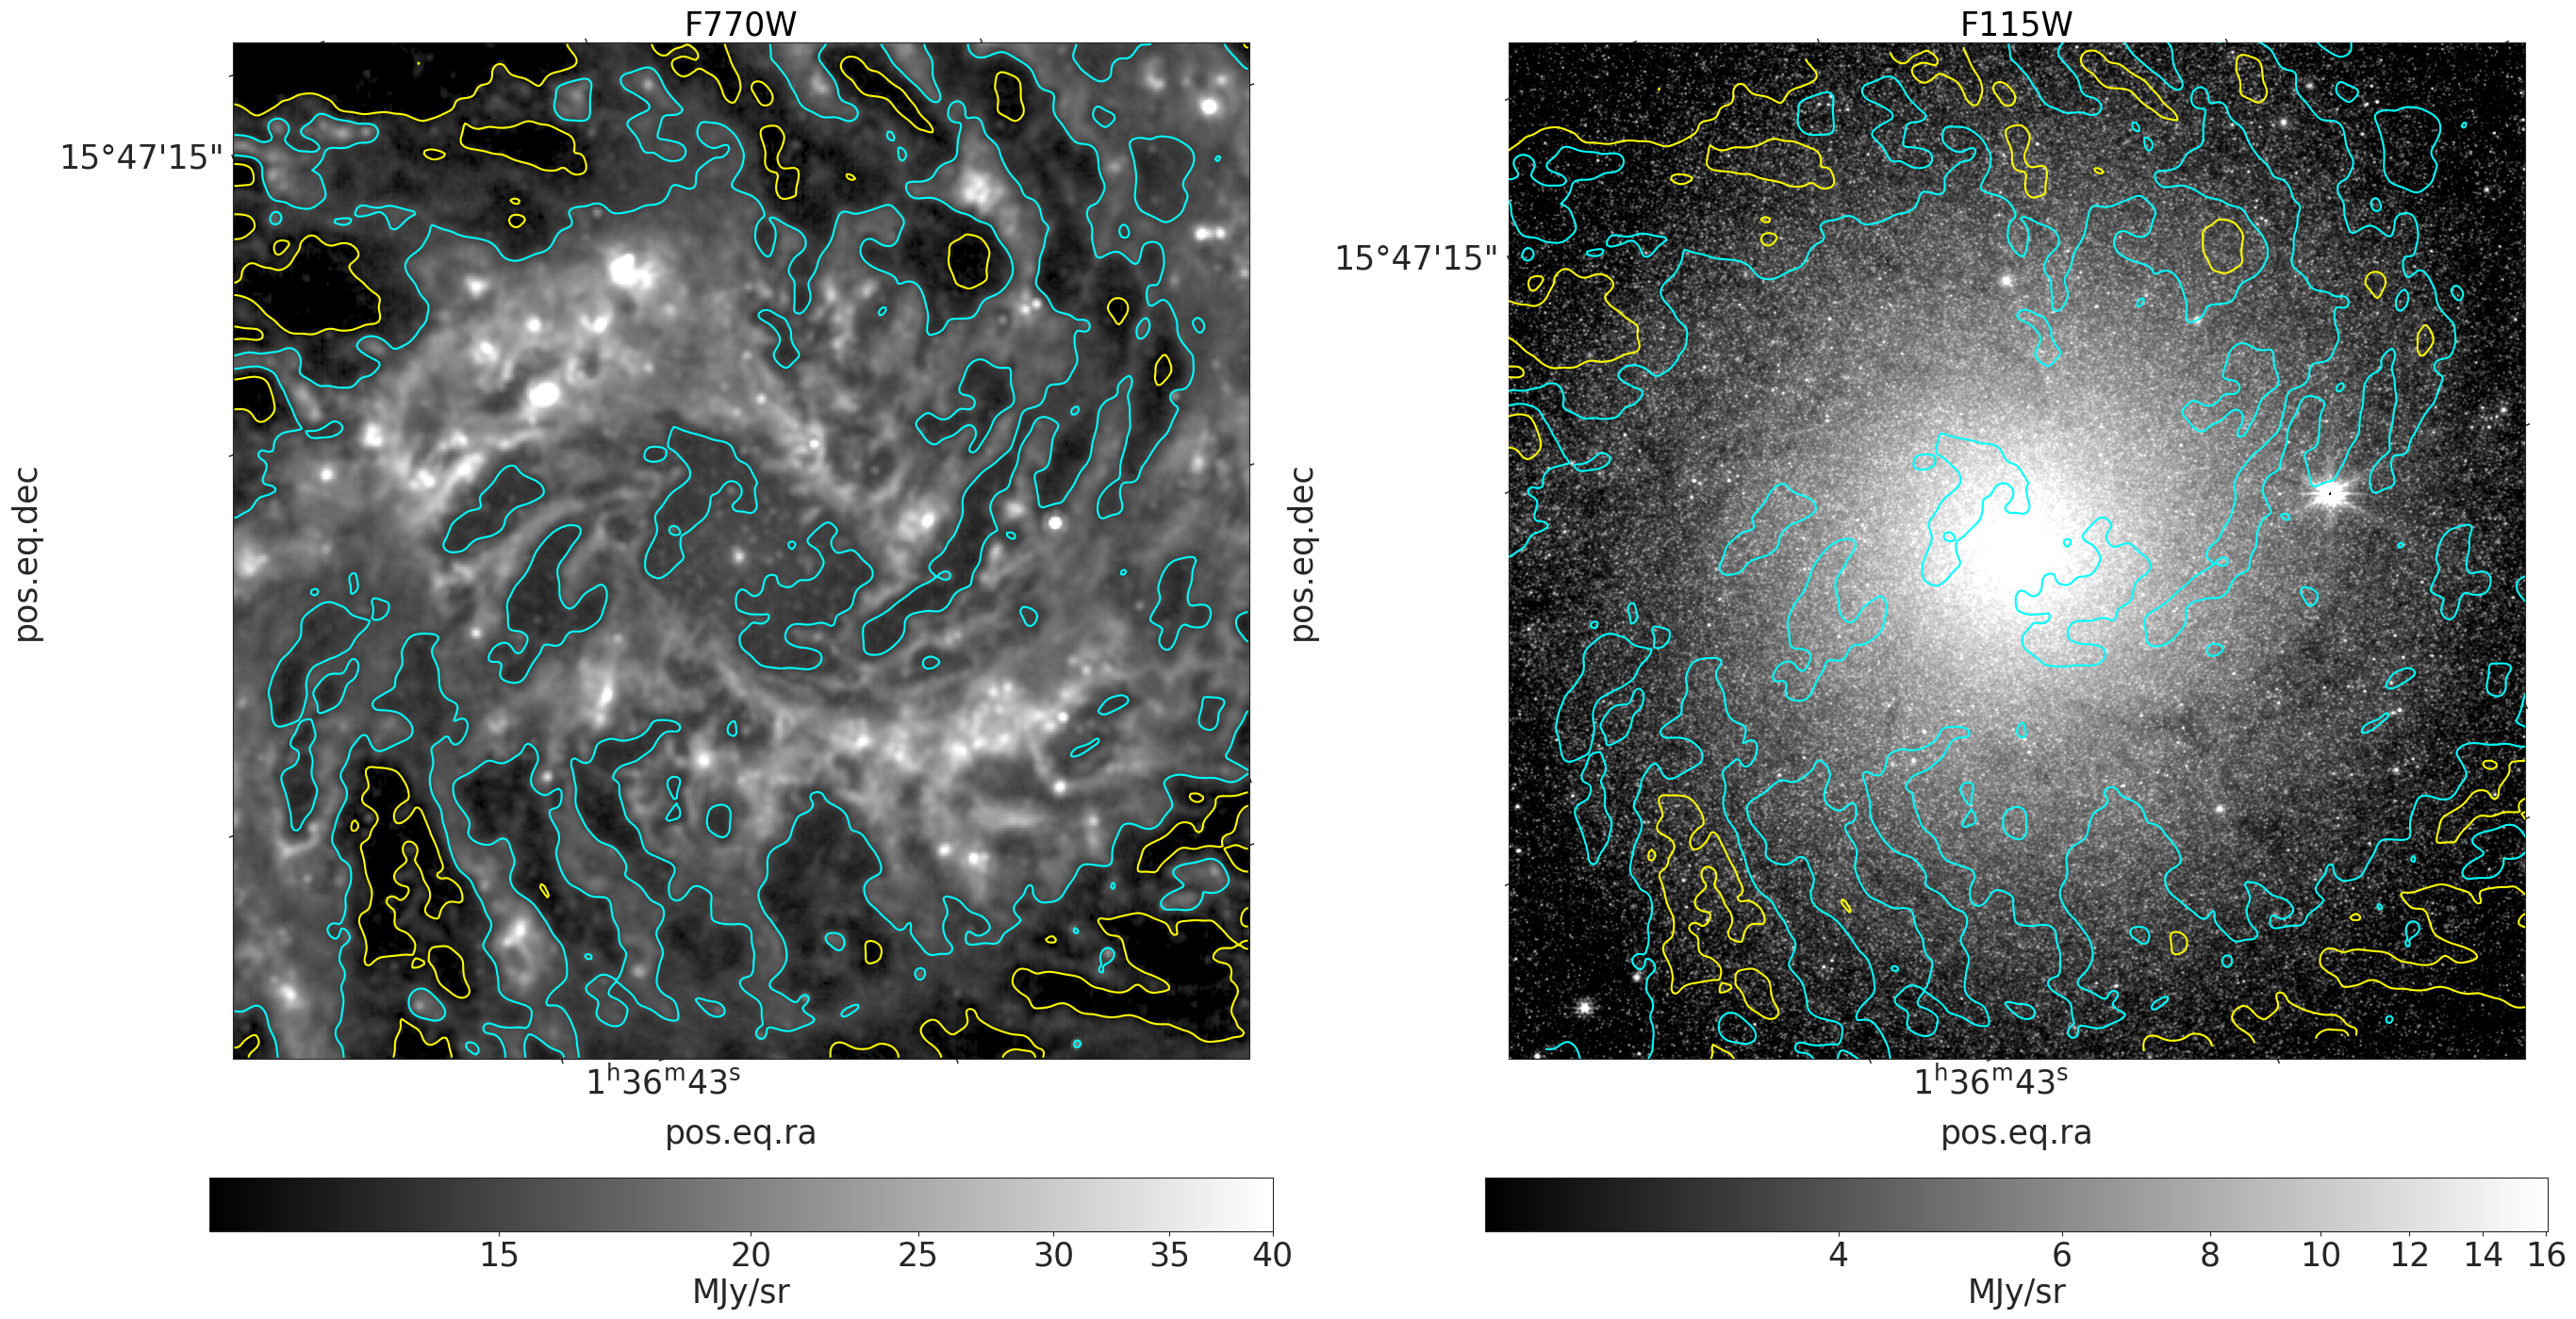

In [17]:
plt.figure(figsize=(32, 20))

ax1 = plt.subplot(1, 2, 1, projection=cutout_m.wcs)

ax1.set_title(filt_m, fontdict=font2)
norm = simple_norm(cutout_m.data, 'sqrt',min_cut=13, max_cut = 40)

img = ax1.imshow(cutout_m.data, norm = norm, cmap='gray')
# MIRI Contours
levels = [13.2,15]
cmap = ListedColormap(['yellow','cyan'])
smooth_data = gaussian_filter(cutout_m.data, 2)
ax1.contour(smooth_data, levels=levels, cmap=cmap)

#ax1.grid(color='red', ls='solid')
cb = plt.colorbar(img, orientation='horizontal', anchor = (0.5, 1.6))
cb.set_label(f"{imh_m['BUNIT']}")

ax2 = plt.subplot(1, 2, 2, projection=cutout_n.wcs)

ax2.set_title(filt_n, fontdict=font2)
norm = simple_norm(cutout_n.data, 'log',min_percent=10, max_percent=99., log_a =10)

img = ax2.imshow(cutout_n.data, norm = norm, cmap='gray')
ax2.contour(smooth_data, levels=levels, cmap=cmap, transform=ax2.get_transform(cutout_m.wcs))
#ax2.grid(color='red', ls='solid')
cb = plt.colorbar(img, orientation='horizontal', anchor = (0.5, 1.6))
cb.set_label(f"{imh_n['BUNIT']}")

#plt.savefig('MIRI_NIRCAM_bubble.eps', bbox_inches='tight')

In [15]:
cutout_n.data.shape

(797, 797)

### **HST**

In [ ]:
images_dir = '../data/NGC_628/HST/'
images = sorted(glob.glob(os.path.join(images_dir, "*/*drc.fits")))

dict_images_hst = {}

for image in images:

    im = fits.open(image)
    if 'FILTER2' in im[0].header.keys():
        f = im[0].header['FILTER2']
    elif 'FILTER' in im[0].header.keys():
        f = im[0].header['FILTER']
    
    if 'CLEAR' in f:
        f = im[0].header['FILTER1']
        
    d = im[0].header['DETECTOR']

    # Image
    if d not in dict_images_hst.keys():
        dict_images_hst[d] = {}
        
    if f not in dict_images_hst[d].keys():
        dict_images_hst[d][f] =  {'images': [image]}
    else:
        dict_images_hst[d][f]['images'].append(image)    
 
print('Available Detectors and Filters\n-------------------------------')
      
for i in dict_images_hst.keys():
    if len(dict_images_hst[i])>0:
        print(f'{i} :', list(dict_images_hst[i].keys()))

In [ ]:
det_n = 'WFC'
filt_n = 'F814W'

hdul_n = fits.open(dict_images_hst[det_n][filt_n]['images'][0])
data_n = hdul_n[1].data

imh_n = hdul_n[1].header
wcs_n = WCS(imh_n)

print(f"Flux units of {filt_n}: {imh_n['BUNIT']}")
hdul_n.close()

In [ ]:
pos = SkyCoord(ra=ra, dec=dec, unit='deg')

In [ ]:
cutout_m = Cutout2D(data_m,pos,size = 50*u.arcsec, wcs = wcs_m)
cutout_n = Cutout2D(data_n,pos,size = 50*u.arcsec, wcs = wcs_n)

In [ ]:
plt.figure(figsize=(30, 20))

ax1 = plt.subplot(1, 2, 1, projection=cutout_m.wcs)

ax1.set_title(filt_m, fontdict=font2)
norm = simple_norm(cutout_m.data, 'sqrt',min_cut=13, max_cut = 40)

img = ax1.imshow(cutout_m.data, norm = norm, cmap='gray')
# MIRI Contours
levels = [13.2,15]
cmap = ListedColormap(['yellow','cyan'])
smooth_data = gaussian_filter(cutout_m.data, 2)
ax1.contour(smooth_data, levels=levels, cmap=cmap)

ax1.grid(color='red', ls='solid')
cb = plt.colorbar(img, orientation='horizontal', anchor = (0.5, 1.5))
cb.set_label(f"{imh_m['BUNIT']}")

ax2 = plt.subplot(1, 2, 2, projection=cutout_n.wcs)

ax2.set_title(filt_n, fontdict=font2)
norm = simple_norm(cutout_n.data, 'sqrt',percent=99.)

img = ax2.imshow(cutout_n.data, norm = norm, cmap='gray')
ax2.contour(smooth_data, levels=levels, cmap=cmap, transform=ax2.get_transform(cutout_m.wcs))
ax2.grid(color='red', ls='solid')
cb = plt.colorbar(img, orientation='horizontal', anchor = (0.5, 1.5))
cb.set_label(f"{imh_n['BUNIT']}")

## **Photutils**

### **PSF**

#### **Synthetic PSF**

In [ ]:

psf_webbpsf_single = create_psf_model(det=det_n, filt=filt_n, fov=51, source=None, create_grid=False, save_psf=False,
                                      detsampled=False)

In [ ]:
filts = [i.split('_')[2] for i in glob.glob(os.path.join(psfs_dir, "*fits"))]
if filt_n not in filts:
    psf_webbpsf_grid = create_psf_model(det=det_n, filt=filt_n, fov=51, source=None, create_grid=True, num=9,
                                        save_psf=True, detsampled=False, all_detectors=False, oversample=5)
else:
    psf_filename = glob.glob(os.path.join('PSF_MODELS/',f'PSF_{filt_n}*{det_n.lower()}.fits'))
    
    with fits.open(psf_filename) as hdu:
        psf_webbpsf_grid = to_griddedpsfmodel(hdu, ext_data=0, ext_header=0)

In [ ]:
webbpsf.gridded_library.display_psf_grid(psf_webbpsf_grid, zoom_in=False, figsize=(14, 10))

#### **Empirical PSF**

In [ ]:
tic = time.perf_counter()

# Source Detection

found_stars, data_out,bkg = find_stars(cutout_n.data, det=det_n, filt=filt_n, threshold=5, smoothen=False,ZP=ZAB_n)

toc = time.perf_counter()

print("Elapsed Time for finding stars:", toc - tic)

In [ ]:
# Source Selection
plt.figure(figsize=(12, 8))
plt.clf()

ax1 = plt.subplot(2, 1, 1)

ax1.set_xlabel('mag', fontdict=font2)
ax1.set_ylabel('sharpness', fontdict=font2)

xlim0 = np.min(found_stars['mag']) - 0.25
xlim1 = np.max(found_stars['mag']) + 0.25
ylim0 = np.min(found_stars['sharpness']) - 0.15
ylim1 = np.max(found_stars['sharpness']) + 0.15

ax1.set_xlim(xlim0, xlim1)
ax1.set_ylim(ylim0, ylim1)

ax1.xaxis.set_major_locator(ticker.AutoLocator())
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.yaxis.set_major_locator(ticker.AutoLocator())
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax1.scatter(found_stars['mag'], found_stars['sharpness'], s=10, color='k')

sh_inf = 0.58
sh_sup = 0.65
mag_inf = 24
mag_sup = 27

ax1.plot([xlim0, xlim1], [sh_sup, sh_sup], color='r', lw=3, ls='--')
ax1.plot([xlim0, xlim1], [sh_inf, sh_inf], color='r', lw=3, ls='--')
ax1.plot([mag_inf, mag_inf], [ylim0, ylim1], color='r', lw=3, ls='--')
ax1.plot([mag_sup, mag_sup], [ylim0, ylim1], color='r', lw=3, ls='--')

ax2 = plt.subplot(2, 1, 2)

ax2.set_xlabel('mag', fontdict=font2)
ax2.set_ylabel('roundness', fontdict=font2)

ylim0 = np.min(found_stars['roundness2']) - 0.25
ylim1 = np.max(found_stars['roundness2']) - 0.25

ax2.set_xlim(xlim0, xlim1)
ax2.set_ylim(ylim0, ylim1)

ax2.xaxis.set_major_locator(ticker.AutoLocator())
ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax2.yaxis.set_major_locator(ticker.AutoLocator())
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())

round_inf = -0.20
round_sup = 0.20

ax2.scatter(found_stars['mag'], found_stars['roundness2'], s=10, color='k')

ax2.plot([xlim0, xlim1], [round_sup, round_sup], color='r', lw=3, ls='--')
ax2.plot([xlim0, xlim1], [round_inf, round_inf], color='r', lw=3, ls='--')
ax2.plot([mag_inf, mag_inf], [ylim0, ylim1], color='r', lw=3, ls='--')
ax2.plot([mag_sup, mag_sup], [ylim0, ylim1], color='r', lw=3, ls='--')

plt.tight_layout()

In [ ]:
plt.figure(figsize=(5,5))
x = found_stars[(found_stars['mag']>24.95) & (found_stars['mag']<26.05)]['sharpness'].value
y,x,_= plt.hist(x,bins=50)
x_mid =  0.5*(x[:-1] + x[1:])
init = models.Gaussian1D()
fit = LevMarLSQFitter()
model = fit(init, x_mid,y)
plt.plot(x,model(x), color='red')
plt.title(f'Roundess at mag=1')
plt.xlabel('Roundess')
plt.ylabel('Counts')
plt.legend(['Data',f'Gaussian Fit\n' + \
                        r'$\mu$ = ' + f'{np.round(model.mean.value,3)}\n'+ \
                        r'$\sigma$ = ' + f'{np.round(model.stddev.value,3)}'])

In [ ]:
model.mean.value - 3*model.stddev.value, model.mean.value + 3*model.stddev.value

In [ ]:
found_table_sel = select_stars(found_stars, mag_inf, mag_sup, round_inf, round_sup, sh_inf, sh_sup, min_sep=12)

In [ ]:
positions = np.transpose([found_table_sel['xcentroid'], found_table_sel['ycentroid']])
apers = CircularAperture(positions, 6)
ax = plt.subplot(1,1,1)
ax.imshow(cutout_n.data, norm=norm, cmap='gray')
apers.plot(ax, color='red');

In [ ]:
# Building Empirical PSF
epsf = build_epsf(cutout_n.data, det=det_n, filt=filt_n, size=15, found_table=found_table_sel, oversample=1, iters=10)

In [ ]:
plt.imshow(epsf.data, norm=col.LogNorm())

In [ ]:
psf = epsf.data/epsf.data.sum()

In [ ]:
positions = np.transpose([8,8])

apers = CircularAperture(positions, 3)
bags  = CircularAnnulus(positions ,5,7)

phot = aperture_photometry(psf,[apers,bags])

phot['sky_flux'] = phot['aperture_sum_1']*apers.area/bags.area

phot['flux'] = phot['aperture_sum_0'] - phot['sky_flux']
phot['flux_err'] = np.sqrt(phot['flux'] + phot['sky_flux'])

In [ ]:
ax = plt.subplot(1,1,1)
norm = simple_norm(psf,'sqrt',percent=99.)
ax.imshow(psf, norm=norm, cmap='gray')
apers.plot(ax, color='red');
bags.plot(ax)

In [ ]:
aper_corr = phot['flux'].value[0]

In [ ]:
aper_corr

### **Photometry**

In [ ]:
psf_phot_table, residual_image, phot, bkg = psf_phot(data=cutout_n.data, det=det_n, filt=filt_n, th=5, psf=epsf,
                                                fit_shape=(15,15), min_sep=1, save_residuals=True, header=imh_n,
                                                save_output=True, maxiters=1,ZP=ZAB_n,sub_shape=(15,15), save_bkg=True)

In [ ]:
m = np.arange(22,28,0.05)
psf = psf_webbpsf_grid.data[0].max()
flux_max = 10**(-0.4*(m-ZAB_n))
bkg_median = bkg.background_median

lim_mag = m[flux_max<5*bkg_median][0]
print(f'Limiting Magnitude for SNR = 5 : {np.round(lim_mag,4)}')

In [ ]:
bkg.background_median

In [ ]:
plt.figure(figsize=(7,5))
mag = psf_phot_table['mag']
mag_err = psf_phot_table['mag_err']
plt.scatter(mag,mag_err,s=1, color='black')
plt.xlabel('mag')
plt.ylabel('mag_err')

In [ ]:
fig = plt.figure(figsize=(20,10))
ax= fig.subplots(1,2)

ax[0].plot(m,flux_max,'-')
ax[0].plot([22,28],[5*bkg_median,5*bkg_median], 'r--')
ax[0].set_ylabel('Peak flux')
ax[0].set_xlabel('mag (AB)')
ax[0].annotate(f'mag limit : {np.round(lim_mag,4)}', (lim_mag, 5*bkg_median ))

ax[1].plot(m[:-1],flux_max[:-1] - flux_max[1:],'-')
ax[1].plot([22,28],[5*bkg_median,5*bkg_median], 'r--')
ax[1].set_ylabel(f'Peak flux difference for {np.round(m[1]-m[0],2)} mag difference ')
ax[1].set_xlabel('mag (AB)')

In [ ]:
plt.figure(figsize=(7,5))
mags = psf_phot_table['mag']
plt.hist(mags, bins=np.arange(mags.min(), mags.max(), 0.05 ))
plt.xlabel('mag')
plt.ylabel('Counts');

In [ ]:
plt.figure(figsize=(7,5))
x = psf_phot_table['mag']
y = psf_phot_table['cfit']

plt.scatter(x,y,s=1)

In [ ]:
psf_phot_table

In [ ]:
dict_images

In [ ]:
out_dir, region, filt_n

In [ ]:
os.system(f"python ../scripts/to_table.py --f ../{out_dir}/{region}/{filt_n}/out")

In [ ]:
phot_table = Table.read(f"../{out_dir}/{region}/{filt_n}/photometry.fits")

In [ ]:
phot_table.rename_columns(['mag_vega'],[f'mag_vega_{filt_n}'])

In [ ]:
hdu = fits.open(f"../{out_dir}/{region}/{filt_n}/data_conv.fits")[1]

In [ ]:
wcs = WCS(hdu.header)

In [ ]:
positions = np.transpose([phot_table['x']+0.25, phot_table['y']-1.25])

In [ ]:
coords = np.array(wcs.pixel_to_world_values(positions))
phot_table['ra'] = coords[:,0]
phot_table['dec'] = coords[:,1]

In [ ]:
x = phot_table[f'mag_vega_{filt_n}']
y = phot_table['mag_err']

fig = plt.figure(figsize=(7,7))
ax = fig.subplots(1,1)
ax.scatter(x,y, s =0.5,marker = '.', color='black')
ax.set_xlabel(r'$mag_{vega}$')
ax.set_ylabel(r'$mag_{err}$')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True,
               bottom = True, left = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")
ax.set_title(f"{filt_n}")
plt.grid()

In [ ]:
x = phot_table[f'mag_vega_{filt_n}']
y = phot_table['SNR']

fig = plt.figure(figsize=(10,5))
ax = fig.subplots(1,1)
ax.scatter(x,y, s =0.5,marker = '.', color='black')
ax.set_xlabel(r'$mag_{vega}$')
ax.set_ylabel('SNR')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True,
               bottom = True, left = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")
ax.set_title(f"{filt_n}")

plt.grid()

In [ ]:
# Source Selection
plt.figure(figsize=(12, 8))
plt.clf()

ax1 = plt.subplot(2, 1, 1)

ax1.set_xlabel('mag (vega)', fontdict=font2)
ax1.set_ylabel('sharpness', fontdict=font2)

xlim0 = np.min(phot_table[f'mag_vega_{filt_n}']) - 0.25
xlim1 = np.max(phot_table[f'mag_vega_{filt_n}']) + 0.25
ylim0 = np.min(phot_table['sharpness']**2) - 0.15
ylim1 = np.max(phot_table['sharpness']**2) + 0.15

ax1.set_xlim(xlim0, xlim1)
ax1.set_ylim(ylim0, ylim1)

ax1.xaxis.set_major_locator(ticker.AutoLocator())
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.yaxis.set_major_locator(ticker.AutoLocator())
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax1.scatter(phot_table[f'mag_vega_{filt_n}'], phot_table['sharpness']**2, s=10, color='k')

sh_inf = 0.5
sh_sup = 0
mag_inf = 24
mag_sup = 27

ax1.plot([xlim0, xlim1], [sh_sup, sh_sup], color='r', lw=3, ls='--')
ax1.plot([xlim0, xlim1], [sh_inf, sh_inf], color='r', lw=3, ls='--')
ax1.plot([mag_inf, mag_inf], [ylim0, ylim1], color='r', lw=3, ls='--')
ax1.plot([mag_sup, mag_sup], [ylim0, ylim1], color='r', lw=3, ls='--')

ax2 = plt.subplot(2, 1, 2)

ax2.set_xlabel('mag', fontdict=font2)
ax2.set_ylabel('roundness', fontdict=font2)

ylim0 = np.min(phot_table['obj_roundness']) - 0.25
ylim1 = np.max(phot_table['obj_roundness']) - 0.25

ax2.set_xlim(xlim0, xlim1)
ax2.set_ylim(ylim0, ylim1)

ax2.xaxis.set_major_locator(ticker.AutoLocator())
ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax2.yaxis.set_major_locator(ticker.AutoLocator())
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())

round_inf = -0.20
round_sup = 0.20

ax2.scatter(phot_table[f'mag_vega_{filt_n}'], phot_table['roundness'], s=10, color='k')

ax2.plot([xlim0, xlim1], [round_sup, round_sup], color='r', lw=3, ls='--')
ax2.plot([xlim0, xlim1], [round_inf, round_inf], color='r', lw=3, ls='--')
ax2.plot([mag_inf, mag_inf], [ylim0, ylim1], color='r', lw=3, ls='--')
ax2.plot([mag_sup, mag_sup], [ylim0, ylim1], color='r', lw=3, ls='--')

plt.tight_layout()

In [ ]:
x = phot_table['obj_crowd']

plt.hist(x, bins=np.arange(x.min(), x.max(),0.2))
plt.xlabel('Crowd');

In [ ]:
# NIRCAM Filter Short (Warfield et.al)
if filt_n in ['F115W', 'F150W','F200W']:
    phot_table1 = phot_table[ (phot_table['sharpness']**2 <= 0.01) &
                                (phot_table['obj_crowd'] <=  0.5) &
                                (phot_table['flags']     <=    2) &
                                (phot_table['type']      <=    2)]
    
    phot_table2 = phot_table[ ~((phot_table['sharpness']**2 <= 0.01) &
                                (phot_table['obj_crowd'] <=  0.5) &
                                (phot_table['flags']     <=    2) &
                                (phot_table['type']      <=    2))]
    print('NIRCAM SHORT')

if filt_n in ['F277W', 'F335M', 'F444W']:
    # NIRCAM Filter Long
    phot_table1 = phot_table[ (phot_table['sharpness']**2 <= 0.02) &
                            (phot_table['obj_crowd'] <=  0.5) &
                            (phot_table['flags']     <=    2) &
                            (phot_table['type']      <=    2)]
    
    phot_table2 = phot_table[ ~((phot_table['sharpness']**2 <= 0.02) &
                        (phot_table['obj_crowd'] <=  0.5) &
                        (phot_table['flags']     <=    2) &
                        (phot_table['type']      <=    2))]
    print('NIRCAM LONG')
    
if filt_n in ['F435W', 'F555W', 'F814W']:
    # HST ACS
    phot_table1 = phot_table[ (phot_table['sharpness']**2 <   0.2) &
                            (phot_table['obj_crowd'] <  2.25) &
                            (phot_table['flags']     <=    2) &
                            (phot_table['type']      <=    2) &
                            (phot_table['SNR']       >     4)]
    
    phot_table2 = phot_table[ ~((phot_table['sharpness']**2 <   0.2) &
                        (phot_table['obj_crowd'] <  2.25) &
                        (phot_table['flags']     <=    2) &
                        (phot_table['type']      <=    2) &
                        (phot_table['SNR']       >     4))]
    print("HST ACS/WFC")

if filt_n in ['F275W', 'F336W']:
    # HST ACS
    phot_table1 = phot_table[ (phot_table['sharpness']**2 <   0.15) &
                            (phot_table['obj_crowd'] <  1.3) &
                            (phot_table['flags']     <=    2) &
                            (phot_table['type']      <=    2) &
                            (phot_table['SNR']       >     4)]
    
    phot_table2 = phot_table[ ~((phot_table['sharpness']**2 <   0.15) &
                        (phot_table['obj_crowd'] <  1.3) &
                        (phot_table['flags']     <=    2) &
                        (phot_table['type']      <=    2) &
                        (phot_table['SNR']       >     4))]
    print("HST WFC3/UVIS")
    
phot_table1['flag_phot'] = 1
phot_table2['flag_phot'] = 0 

phot_table = vstack([phot_table1, phot_table2])

In [ ]:
len(phot_table1), len(phot_table2), len(phot_table1) + len(phot_table2)

In [ ]:
phot_table.write(f"../{out_dir}/{region}/{filt_n}/{filt_n}_photometry_filt.fits",overwrite=True)

In [ ]:
with open(f"../{out_dir}/{region}/{filt_n}/{filt_n}.reg",'w+') as f:
    f.write("""# Region file format: DS9 version 4.1
global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1
fk5\n""")
    for row in phot_table1:
        ra = row['ra']
        dec = row['dec']
        f.write(f"""circle({ra},{dec},0.03")\n""")
f.close()

# **Photometric Analysis**

## **Functions**

In [9]:
def rotate_coords(x,y,h=0,k=0,theta=0,Sx=1,Sy=1):
    
    X = np.array([x,y,x**0])

    T = np.array([[1,0,h],
                 [0,1,k],
                 [0,0,1]])

    Tinv =  np.array([[1,0,-h],
                      [0,1,-k],
                      [0,0,1]])

    R = np.array([[np.cos(theta), -np.sin(theta),0],
                  [np.sin(theta),  np.cos(theta),0],
                  [0            ,              0,1]])
    
    S = np.array([[Sx,0,0],
                  [0, Sy,0],
                  [0,0,1]])
    
    X_n = T@S@R@Tinv@X
    
    return X_n[0], X_n[1]

In [10]:
def gen_CMD(filt1='f115w', filt2='f150w',name=None, Av=0.19, r=333, r_in=None, r_out=None, dismod=29.95, xlims=[-0.5,2.5], ylims=[18,28],label=3, met=0.02,
           cmd=None, out_dir='PHOT_OUTPUT_EPSF', Av_ = 3, Av_x=2, Av_y=19,
           flag=111, gen_kde=False, add_ref=False, regions=['bubble','bkg1', 'bkg2','bkg3'],add_ext='',
           ra_col = 'ra_1', dec_col= 'dec_1', mag_err=0.1,
           comp_flag=False, ref_xpos=-0.25):
    
    if met is not None:
        cmd = cmd[cmd['Zini']==met]
              
    fig = plt.figure(figsize=(len(regions)*12,10))
    for i,region in enumerate(regions):
        
        ax = fig.add_subplot(1,len(regions),int(i+1))
        
        if name is None:
            tab_bub = Table.read(f"../{out_dir}/{region}/{filt1}_{filt2}{add_ext}.fits")
        else:
            tab_bub = Table.read(f"../{out_dir}/{region}/{name}.fits")
        
        mag_errs = [i for i in tab_bub.keys() if 'mag_err' in i]
        
        for i in mag_errs:
            tab_bub = tab_bub[tab_bub[i]<=mag_err_lim]


        AF1 =  Av_dict[filt1]*Av
        AF2 =  Av_dict[filt2]*Av
        
        ra_cen = regions_dict[region]['ra']
        dec_cen = regions_dict[region]['dec']
        
        tab_bub['r'] = angular_separation(tab_bub[ra_col]*u.deg,tab_bub[dec_col]*u.deg,
                                          ra_cen*u.deg, dec_cen*u.deg).to(u.arcsec).value
        
        if (r_out is None or r_in is None) :
            r_in = 0
            r_out = r
            
        if r_out is not None:    
            tab_bub = tab_bub[ (tab_bub['r']>=r_in) & (tab_bub['r'] <r_out)]

        x = tab_bub[f'mag_vega_{filt1.upper()}'] - tab_bub[f'mag_vega_{filt2.upper()}']
        y = tab_bub[f'mag_vega_{filt2.upper()}'] 
        
        x = x.value.astype(float)
        y = y.value.astype(float)
        
        n_sources = len(x)
        
        if gen_kde:

            # Peform the kernel density estimate
            xx, yy = np.mgrid[xlims[0]:xlims[1]:100j, ylims[0]:ylims[1]:100j]
            positions = np.vstack([xx.ravel(), yy.ravel()])
            values = np.vstack([x, y])

            kernel = gaussian_kde(values, bw_method=0.075)
            f = np.reshape(kernel(positions), xx.shape)

            f = f.T
            img = ax.imshow(f, cmap='jet', 
                          extent=[xlims[0], xlims[1], 
                                  ylims[0], ylims[1]],
                           interpolation='nearest', aspect='auto')
            
        else:
            ax.scatter(x,y, s=0.2, color='black', label='data')
            
        ax1 = ax.twinx()  # instantiate a second axes that shares the same x-axis

        ax1.set_ylabel(r'$M_{' + f'{filt2.upper()}' + r'}$')  # we already handled the x-label with ax1

        ax.set_xlabel(f"{filt1.upper()} - {filt2.upper()}")
        ax.set_ylabel(filt2.upper())
        

        ref = tab_bub[f'mag_vega_{filt2.upper()}']
        ref_new = np.arange(np.ceil(y.min()),np.floor(y.max()),0.5)
        
        if 'mag_err_1' in tab_bub.keys():
            mag_err1 = interp1d(ref, tab_bub['mag_err_1'])(ref_new)
            mag_err2 = interp1d(ref, tab_bub['mag_err_2'])(ref_new)
            
        elif 'mag_err_1_1' in tab_bub.keys():
            mag_err1 = interp1d(ref, tab_bub['mag_err_1_1'])(ref_new)
            mag_err2 = interp1d(ref, tab_bub['mag_err_2_1'])(ref_new)

        col_err = np.sqrt(mag_err1**2 + mag_err2**2)

        x = ref_xpos + 0*ref_new
        y = ref_new
        yerr = mag_err1
        xerr = col_err

        ax.errorbar(x, y,yerr,xerr,fmt='o', color = 'red', markersize=0.5, capsize=2) 
        
        if cmd is not None:
            for i,age in enumerate(ages_):

                t = cmd[np.round(cmd['logAge'],1)==age].copy()
                
                t_ = t[t['label']<=label]
                x =  (t_[f'{filt1.upper()}mag'] + AF1) - (t_[f'{filt2.upper()}mag'] + AF2)
                y =  t_[f'{filt2.upper()}mag'] + AF2 + dismod
                ax.plot(x,y, linewidth=3, label=age_lin[i], alpha=0.6)
                
        else: 
            met = ' '

        ax.set_ylim(ylims[0], ylims[1])
        ax.set_xlim(xlims[0], xlims[1]) 
        
        yticks = ax.get_yticks()
        yticks_n = yticks - dismod
        
        dy = yticks_n - np.floor(yticks_n)
        ax1.set_yticks(yticks + dy, np.floor(yticks_n))
        
        ax1.set_ylim(ylims[0], ylims[1])
        ax1.set_xlim(xlims[0], xlims[1]) 
        
        ax.invert_yaxis()
        ax1.invert_yaxis()
        ax.set_title(region.capitalize() + f" | No of sources: {n_sources} | Z : {met}", fontsize=30)
            
        if add_ref:
            ax.plot([xlims[0], xlims[1]],[25,25], '--r', zorder=200)
            ax.plot([xlims[0], xlims[1]],[24.5,24.5], '--r', zorder=200)
            ax.plot([xlims[0], xlims[1]],[23,23], '--r', zorder=200)
         
        if comp_flag:
            comp_f1 = comp[region][filt1]
            comp_f2 = comp[region][filt2]

            y0 = comp_f2
            x0 = comp_f1 - comp_f2

            ax.plot([x0,xlims[1]],[y0,y0])
            
        ax.legend(fontsize=15)
        ax.xaxis.set_major_locator(AutoLocator())
        ax.xaxis.set_minor_locator(AutoMinorLocator())

        ax.yaxis.set_major_locator(AutoLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        
        ax1.yaxis.set_minor_locator(AutoMinorLocator())

        ax.tick_params(which='both', length=14,direction="in", bottom=True, top=True,left=True)
        ax.tick_params(which='minor', length=8)
        
        ax1.tick_params(which='both', length=14,direction="in", right=True)
        ax1.tick_params(which='minor', length=8)

        AF1_ =  Av_dict[filt1]*Av_
        AF2_ =  Av_dict[filt2]*Av_

        dx = AF1_ - AF2_
        dy = AF1_

        ax.annotate('', xy=(Av_x, Av_y),
                     xycoords='data',
                     xytext=(Av_x+dx, Av_y+dy),
                     textcoords='data',
                     arrowprops=dict(arrowstyle= '<|-',
                                     color='black',
                                     lw=0.5,
                                     ls='-')
                   )
            
        ax.annotate(f'Av = {Av_}', xy=(Av_x-0.1, Av_y-0.1))
        
    fig.tight_layout()
    return fig, ax

In [11]:
def gen_CMD_xcut( filt1='f115w', filt2='f150w',inp='bubble', name=None, Av=0.19, r=333,
                r_in=None, r_out=None, met=0.02,
                dismod=29.95, x_cen=1594/2, y_cen=1594/2, cmd=None,
                out_dir='PHOT_OUTPUT_EPSF', xlims=[-0.5,2.5], ylims=[18,30],
                age=9.0, cmd_xlo = None, cmd_xhi= None,
                l_lo = 22, l_hi=26.5, dl=0.5, Av_ = 3,
                Av_x=2, Av_y=22, flag=111, fit_isochrone=True):
    
    if met is not None:
        cmd = cmd[cmd['Zini']==met]
    
    cmd_ylo = l_lo - dl
    cmd_yhi = l_hi + dl
    
    if name is None:
            tab_bub = Table.read(f"../{out_dir}/{inp}/{filt1}_{filt2}.fits")
    else:
        tab_bub = Table.read(f"../{out_dir}/{inp}/{name}.fits")
        
    mag_errs = [i for i in tab_bub.keys() if 'mag_err' in i]
        
    for i in mag_errs:
        tab_bub = tab_bub[tab_bub[i]<=mag_err_lim]


    AF1 =  Av_dict[filt1]*Av
    AF2 =  Av_dict[filt2]*Av

    ra_cen = regions_dict[region]['ra']
    dec_cen = regions_dict[region]['dec']

    tab_bub['r'] = angular_separation(tab_bub[ra_col]*u.deg,tab_bub[dec_col]*u.deg,
                                      ra_cen*u.deg, dec_cen*u.deg).to(u.arcsec).value

    if (r_out is None or r_in is None) and r is not None:
        r_in = 0
        r_out = r
        
    if r_out is not None:    
        tab_bub = tab_bub[ (tab_bub['r']>=r_in) & (tab_bub['r'] < r_out)]



    x = tab_bub[f'mag_vega_{filt1.upper()}'] - tab_bub[f'mag_vega_{filt2.upper()}']
    y = tab_bub[f'mag_vega_{filt2.upper()}'] 

    x = x.value.astype(float)
    y = y.value.astype(float)
    
    if cmd_xlo is None or cmd_xhi is None:
        cmd_xlo = x.mean() - 0.5

        cmd_xhi = x.mean() + 0.5

    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(1,1,1)

    theta = np.arctan(AF1/(AF1-AF2)) #
    
    ax.scatter(x,y, s=0.1, color='black')
    if cmd is not None:
        t = cmd[np.round(cmd['logAge'],1)==age].copy()
        met = np.array(cmd['MH'])[0]
        x_i =  (t[f'{filt1.upper()}mag'] + AF1) - (t[f'{filt2.upper()}mag'] + AF2)
        y_i =  t[f'{filt2.upper()}mag'] + AF2 + dismod
        
        x_i = np.array(x_i)
        y_i = np.array(y_i)
        
        x_iso = x_i.copy()
        y_iso = y_i.copy()
        
        x_i = x_i[np.where( (y_i>=cmd_ylo) & (y_i<=cmd_yhi))[0]]
        y_i = y_i[np.where( (y_i>=cmd_ylo) & (y_i<=cmd_yhi))[0]]

        y_i = y_i[np.where( (x_i>=cmd_xlo) & (x_i<=cmd_xhi))[0]]
        x_i = x_i[np.where( (x_i>=cmd_xlo) & (x_i<=cmd_xhi))[0]]
        
        ax.plot(x_i,y_i,alpha=0.8, zorder=200)
        

        ax.legend(['data', f'age = {age}'])

    x_l = np.linspace(0, 2)    

    # Bin mid points
    y_rgbn = np.arange(l_lo, l_hi, dl)
    
    y_rgb_mid = y_rgbn[:-1]+dl/2   
    
    if fit_isochrone:
        init = models.Linear1D()
        fit = fitting.LinearLSQFitter()
        model_iso = fit(init, y_i, x_i)
        
    else:
        model_iso = interp1d(y_i, x_i)
        
    x_rgb_mid = model_iso(y_rgb_mid)
    
    ax.scatter(x_rgb_mid, y_rgb_mid, c='r' ,zorder = 200)

    dats = []
    
    x0 = 1# x.mean()
    for y0 in y_rgbn[:-1]:

        # Extinction Vector
        x0 = model_iso(y0)
        y_Avl = y0 + np.tan(theta)*(x_l-x0)
        
        x01 = model_iso(y0 + dl)
        y_Avu = y0 + dl + np.tan(theta)*(x_l-x01)

        ax.plot(x_l,y_Avl, color='grey')
        ax.plot(x_l,y_Avu, color='grey')

        init = models.Linear1D()
        fit = fitting.LinearLSQFitter()
        
        model_Avl = fit(init, x_l, y_Avl)
        model_Avu = fit(init, x_l, y_Avu)

        c1 = (y>model_Avl(x)) & (y<=model_Avu(x))

        yn = y[np.where(c1)]
        xn = x[np.where(c1)]
        
        dat = np.array([xn, yn])
        dats.append(dat)
    
    ax.set_xlabel(f"{filt1.upper()} - {filt2.upper()}")
    ax.set_ylabel(filt2.upper())

    ax.set_ylim(ylims[0], ylims[1])
    ax.set_xlim(xlims[0], xlims[1])  
    ax.invert_yaxis()
    ax.set_title(inp.capitalize())

    ax.xaxis.set_major_locator(AutoLocator())
    ax.xaxis.set_minor_locator(AutoMinorLocator())

    ax.yaxis.set_major_locator(AutoLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    ax.tick_params(which='both', length=7,direction="in", bottom=True, top=True,left=True, right=True)
    ax.tick_params(which='minor', length=4)
    
    AF1_ =  Av_dict[filt1]*Av_
    AF2_ =  Av_dict[filt2]*Av_
    
    dx = AF1_ - AF2_
    dy = AF1_

    ax.annotate('', xy=(Av_x, Av_y),
                 xycoords='data',
                 xytext=(Av_x+dx, Av_y+dy),
                 textcoords='data',
                 arrowprops=dict(arrowstyle= '<|-',
                                 color='black',
                                 lw=0.5,
                                 ls='-')
               )

    ax.annotate(f'Av = {Av_}', xy=(Av_x-0.1, Av_y-0.1))
    
    return fig, ax, dats, x_rgb_mid, y_rgb_mid, y_rgbn

In [12]:
def gen_CMD_ycut( filt1='f115w', filt2='f150w',region='bubble', Av=0.19, r=333,
                r_in=None, r_out=None, fig = None, ax = None, met=0.02,
                dismod=29.95, x_cen=1594/2, y_cen=1594/2, cmd=None, label =3,
                out_dir='PHOT_OUTPUT_r25', xlims=[-0.5,2.5], ylims=[18,30],
                age=9.0, cmd_xlo = None, cmd_xhi= None, gen_kde=False,
                l_lo = 22, l_hi=26.5, dl=0.5, Av_ = 3,ref_xpos=0.25,
                Av_x=2, Av_y=22, flag=111, fit_isochrone=True,y0=None):
    if met is not None:
        if 'Zini' in cmd.keys():
            cmd = cmd[cmd['Zini']==met]
        else:
            cmd = cmd[cmd['Zini_1']==met]  
            
    cmd_ylo = l_lo
    cmd_yhi = l_hi
    
    tab_bub = Table.read(f"../{out_dir}/{region}/{filt1}_{filt2}.fits")
        
    mag_errs = [i for i in tab_bub.keys() if 'mag_err' in i]
        
    for i in mag_errs:
        tab_bub = tab_bub[tab_bub[i]<=mag_err_lim]

    AF1 =  Av_dict[filt1]*Av
    AF2 =  Av_dict[filt2]*Av

    ra_cen = regions_dict[region]['ra']
    dec_cen = regions_dict[region]['dec']

    tab_bub['r'] = angular_separation(tab_bub[ra_col]*u.deg,tab_bub[dec_col]*u.deg,
                                      ra_cen*u.deg, dec_cen*u.deg).to(u.arcsec).value

    if r_out is None or r_in is not None :
        r_in = 0
        r_out = r

    if r_out is not None:    
        tab_bub = tab_bub[ (tab_bub['r']>=r_in) & (tab_bub['r'] < r_out)]

    x = tab_bub[f'mag_vega_{filt1.upper()}'] - tab_bub[f'mag_vega_{filt2.upper()}']
    y = tab_bub[f'mag_vega_{filt2.upper()}'] 

    x = x.value.astype(float)
    y = y.value.astype(float)
    
    if cmd_xlo is None or cmd_xhi is None:
        cmd_xlo = x.mean() - 1

        cmd_xhi = x.mean() + 1
    
    if fig is None or ax is None:
        fig = plt.figure(figsize=(7,7))
        ax = fig.add_subplot(1,1,1)
    l = []
    if gen_kde:

        # Peform the kernel density estimate
        xx, yy = np.mgrid[xlims[0]:xlims[1]:100j, ylims[0]:ylims[1]:100j]
        positions = np.vstack([xx.ravel(), yy.ravel()])
        values = np.vstack([x, y])

        kernel = gaussian_kde(values, bw_method=0.075)
        f = np.reshape(kernel(positions), xx.shape)

        f = f.T
        img = ax.imshow(f, cmap='jet', 
                      extent=[xlims[0], xlims[1], 
                              ylims[0], ylims[1]],
                       interpolation='nearest', aspect='auto')
            
    else:
        ax.scatter(x,y, s=0.2, color='black')
        l.append('data')
        
    l = [i for i in cmd.keys() if 'logAge' in i][0]
    
    if cmd is not None:
        t = cmd[np.round(cmd[l],1)==age].copy()
        t = t[t['label']<=label]
        x_i =  (t[f'{filt1.upper()}mag'] + AF1) - (t[f'{filt2.upper()}mag'] + AF2)
        y_i =  t[f'{filt2.upper()}mag'] 
        M = y_i.min()
        y_i +=   AF2 + dismod
        
        x_i = np.array(x_i)
        y_i = np.array(y_i)
        
        x_iso = x_i.copy()
        y_iso = y_i.copy()
        
        x_i = x_i[np.where( (y_i>=cmd_ylo-0.5) & (y_i<=cmd_yhi+0.5))[0]]
        y_i = y_i[np.where( (y_i>=cmd_ylo-0.5) & (y_i<=cmd_yhi+0.5))[0]]

        y_i = y_i[np.where( (x_i>=cmd_xlo-0.2) & (x_i<=cmd_xhi+0.2))[0]]
        x_i = x_i[np.where( (x_i>=cmd_xlo-0.2) & (x_i<=cmd_xhi+0.2))[0]]
        
        ax.plot(x_i,y_i, zorder=200, color='black')
        
        l.append(f'Log(age) = {age}')

    x_l = np.linspace(0, 2)    

    # Bin mid points
    x_rgbn = np.arange(cmd_xlo, cmd_xhi, dl)
    
    x_rgb_mid = x_rgbn[:-1]+dl/2   
    
    if fit_isochrone:
        init = models.Linear1D()
        fit = fitting.LinearLSQFitter()
        model_iso = fit(init, x_i, y_i)
        
    else:
        model_iso = interp1d(x_i, y_i)
    
    if y0 is None:
        y0 = y.mean()
    y_rgb_mid = y0 + x_rgb_mid*0

    dats = []
    
    x0 = 1# x.mean()
    init = models.Linear1D()
    fit = fitting.LinearLSQFitter()
    for x0 in x_rgbn[:-1]:
        
        y_l = np.linspace(cmd_ylo, cmd_yhi)
        x_l = (1/model_iso.slope.value)*(y_l - y0) + x0
        
        y_r = np.linspace(cmd_ylo, cmd_yhi)
        x_r = (1/model_iso.slope.value)*(y_r - y0) + x0 + dl

        ax.plot(x_l,y_l, color='blue')
        ax.plot(x_r,y_r, color='red')

        init = models.Linear1D()
        fit = fitting.LinearLSQFitter()
        
        model_l = fit(init, y_l,x_l)
        model_r = fit(init, y_r,x_r)

        c1 = (x>model_l(y)) & (x<=model_r(y))

        yn = y[np.where(c1)]
        xn = x[np.where(c1)]
        if not gen_kde:
            ax.scatter(xn,yn, s =0.1, color='green', zorder=100)
        dat = np.array([xn, yn])
        dats.append(dat)
    
    ref = tab_bub[f'mag_vega_{filt2.upper()}']
    ref_new = np.arange(np.ceil(y.min()),np.floor(y.max()),0.5)
    mag_err1 = interp1d(ref, tab_bub['mag_err_1'])(ref_new)
    mag_err2 = interp1d(ref, tab_bub['mag_err_2'])(ref_new)

    col_err = np.sqrt(mag_err1**2 + mag_err2**2)

    x = ref_xpos + 0*ref_new
    y = ref_new
    yerr = mag_err1
    xerr = col_err

    ax.errorbar(x, y,yerr,xerr,fmt='o', color = 'red', markersize=0.5, capsize=2, zorder=300)   
    ax.set_xlabel(f"{filt1.upper()} - {filt2.upper()}")
    ax.set_ylabel(filt2.upper())

    ax.set_ylim(ylims[0], ylims[1])
    ax.set_xlim(xlims[0], xlims[1])  
    ax.invert_yaxis()
    title = f" | Z : {met} | " + "$M_" + "{" + f"{filt2.upper()}" +r"}^{TRGB}$ : " + f"{M} | "
    title += r"$A_{" + f"{filt2.upper()}" + r"}$ : " + f"{np.round(AF2,2)}"
    ax.set_title(region.capitalize() + title,
                fontsize=15)

    ax.xaxis.set_major_locator(AutoLocator())
    ax.xaxis.set_minor_locator(AutoMinorLocator())

    ax.yaxis.set_major_locator(AutoLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    ax.tick_params(which='both', length=7,direction="in", bottom=True, top=True,left=True, right=True)
    ax.tick_params(which='minor', length=4)
    ax.legend(l)
    
    return fig, ax, dats, x_rgb_mid, y_rgb_mid, x_rgbn

In [13]:
Av_dict = { 
            'f275w': 2.02499,
            'f336w': 1.67536,
            'f435w': 1.33879,
            'f555w': 1.03065,
            'f814w': 0.59696,
            'f115w': 0.32726,
            'f150w': 0.21461,
            'f200w': 0.13589,
          }

In [14]:
Av_dict = { 
            'f275w': 2.02499,
            'f336w': 1.67536,
            'f435w': 1.33879,
            'f555w': 1.03065,
            'f814w': 0.59696,
            'f115w': 0.419,
            'f150w': 0.287,
            'f200w': 0.195,
          }

In [15]:
regions_dict = {'bubble' : {'ra'   : 24.1859050,
                       'dec'  : 15.7726111,
                       'F115W': 25.4, 
                       'F150W': 24.63,
                       'F200W': 23.53,
                      
                       'F435W': 27.88, 
                       'F555W': 27.48,
                       'F814W': 26.52},
           
           'bkg1'   : {'ra'   : 24.1918038,
                       'dec'  : 15.7600032,
                       'F115W': 26., 
                       'F150W': 25.26,
                       'F200W': 24.21,
                      
                      'F435W': 28.26, 
                       'F555W': 27.94,
                       'F814W': 27.05},
              
           'bkg2'   : {'ra'   : 24.1787197,
                       'dec'  : 15.7543227,
                       'F115W': 26.31, 
                       'F150W': 25.39,
                       'F200W': 24.39,
                      
                      'F435W': 28.26, 
                       'F555W': 27.94,
                       'F814W': 27.05},
              
           'bkg3'   : {'ra'   : 24.1728133,
                       'dec'  : 15.7669357,
                       'F115W': 25.42, 
                       'F150W': 24.55,
                       'F200W': 23.56,
                      
                      'F435W': 27.88, 
                       'F555W': 27.48,
                       'F814W': 26.52},
                
            'center' : {'ra'   : 24.1738983, 
                       'dec'  : 15.7836543,
                       'F115W': 25.42, 
                       'F150W': 24.55,
                       'F200W': 23.56
          }


In [16]:
26*5 -1

129

In [18]:
51*5

255

## **JWST**

### **PARSEC Isochrones**

In [31]:
with open("../data/isochrones_master/cmd_jwst_n.dat") as f:
    dat = f.readlines()

data = []

for i,d in enumerate(dat[13:]):
    if 'Zini' not in d and 'terminated' not in d:
        data.append([float(i) for i in d.split()])
    
        
df_cmd = pd.DataFrame(data,columns=dat[13][2:].split())
df_cmd.to_csv("../data/isochrones_master/cmd_jwst.csv")
df_cmd = df_cmd[(df_cmd['label']<8)]

In [32]:
df_cmd_jwst = pd.read_csv("../data/isochrones_master/cmd_jwst.csv")

In [33]:
ages = np.round(np.arange(6,10.1,0.1),1)
mets = np.unique(df_cmd_jwst['Zini'])

In [34]:
if not os.path.exists('../data/isochrones/JWST'):
    os.mkdir('../data/isochrones/JWST/')
else:
    os.system('rm ../data/isochrones/JWST/*')


for i, age in enumerate(ages):
    
    if len(str(i+1))==1:
        i = '0' + str(i+1)
    else:
        i =  str(i+1)

    for met in [0.02, 0.008]:
        temp = df_cmd_jwst[np.round(df_cmd_jwst['logAge'],1)==age]
        temp = temp[temp['Zini']==met]

        temp = temp[['label', 'Mini', 'F115Wmag', 'F150Wmag', 'F200Wmag', 'Zini', 'logAge']]

        header = list(temp.keys())
        header[0] = '#' + header[0]
        
        if (met==0.02 and age<=9) or (met==0.008 and age>9):
            temp.to_csv(f'../data/isochrones/JWST/{i}_PARSEC1.2S_Z{0.00}_logAGE{age}Myr_JWST_JHK.isoc',sep=' ',
                       index=None, header = header)

In [35]:
ages_ = np.round(np.log10([1e7,2e7, 3e7, 5e7,1e8,5e8, 1e9, 5e9, 1e10]),1)
mag_err_lim = 0.2
SNR_lim = 10

In [36]:
age_lin = []
for i in ages_:
    if i > 6  and i <9:
        i-=6
        age_lin.append(f'{np.ceil(10**i)} Myr')
    elif i >= 9:
        i-=9
        age_lin.append(f'{np.ceil(10**i)} Gyr')
        

### **CMD**

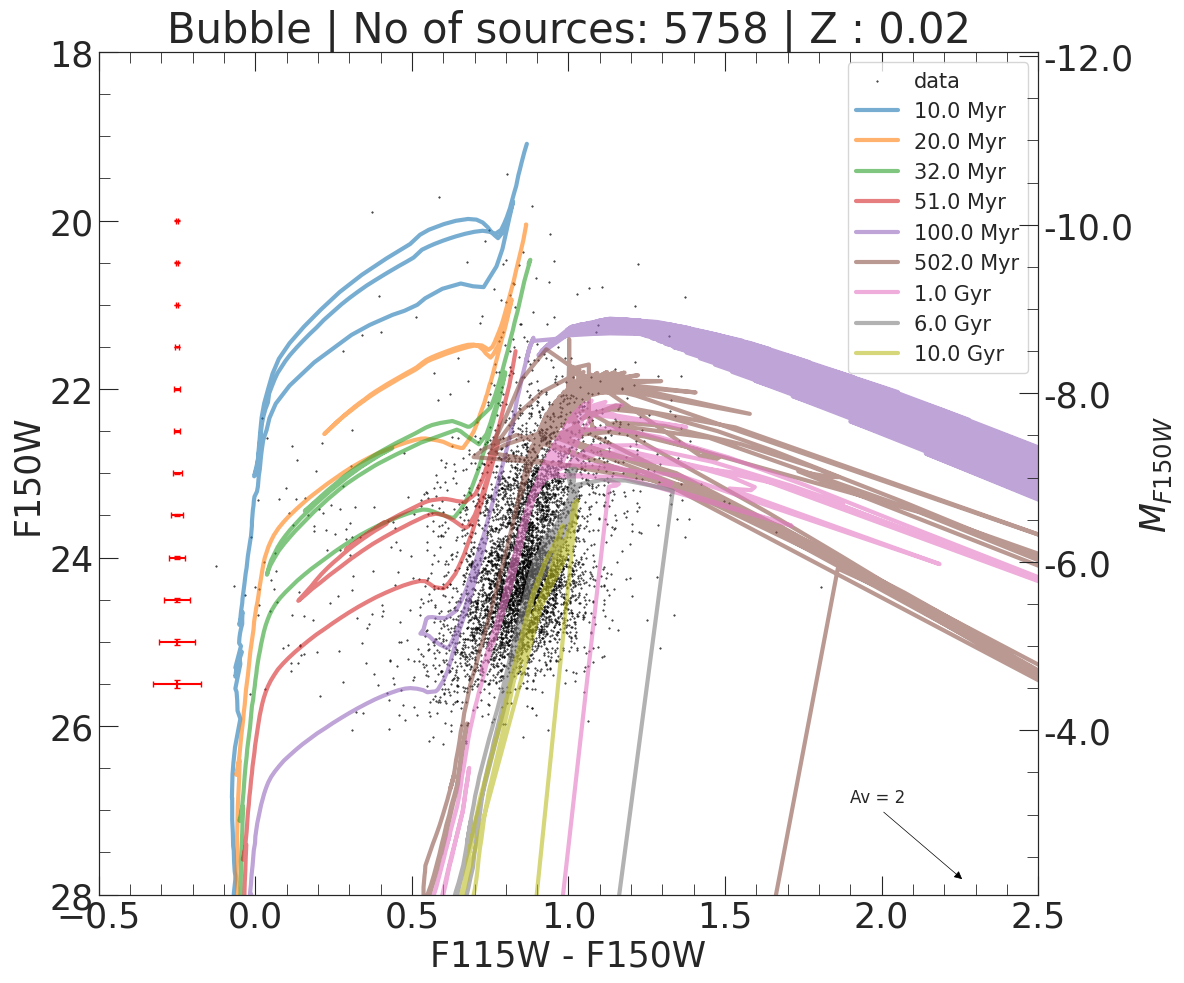

In [196]:
r_in = 0
r_out = 10

fig,ax = gen_CMD('f115w', 'f150w', cmd=df_cmd_jwst, r=None, flag=111, gen_kde=False, 
                 r_in=r_in, r_out=r_out,Av_x=2, Av_y=27, Av_=2,
                 label=10, met=0.02, out_dir='PHOT_OUTPUT_r25',  regions=['bubble'])

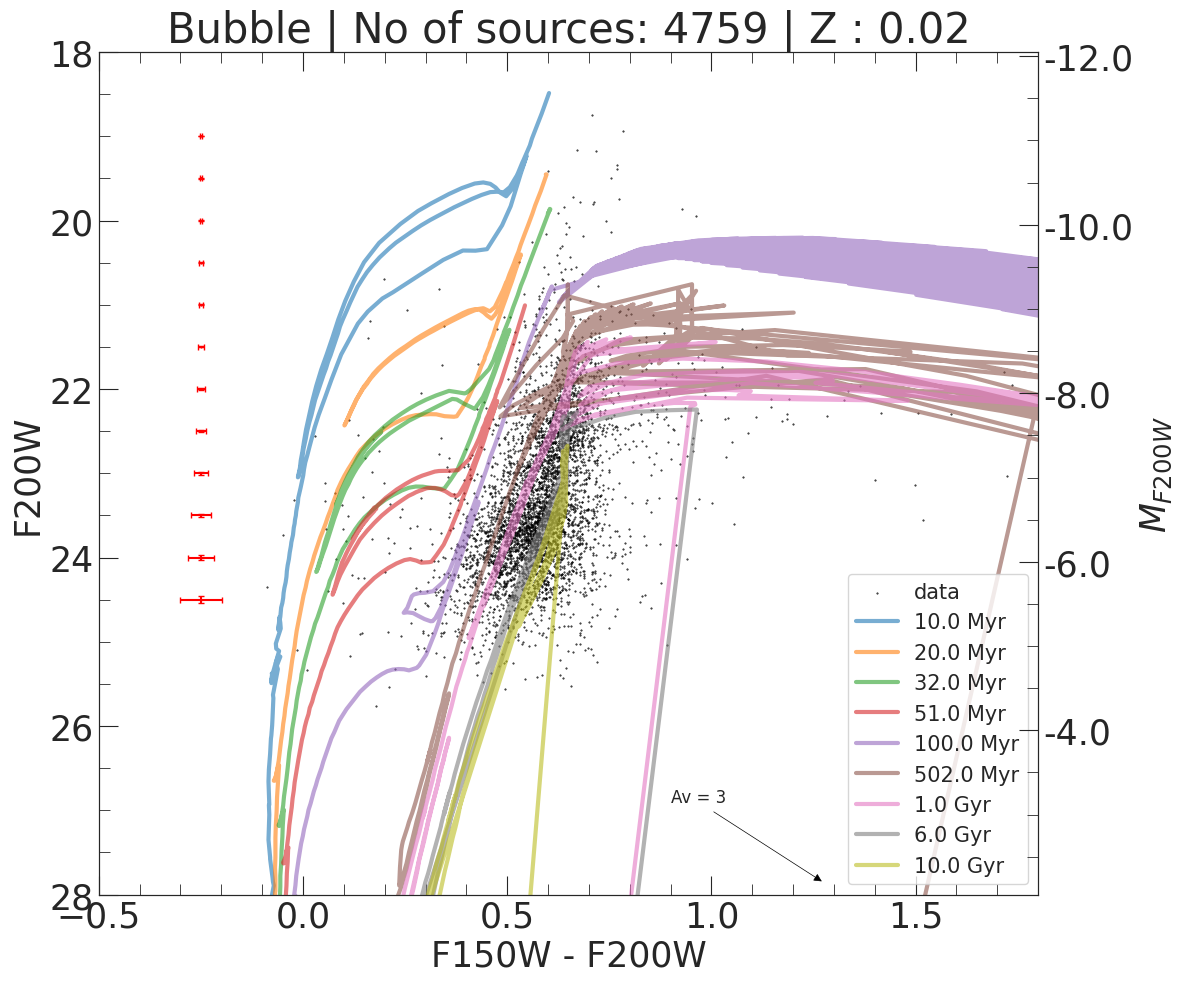

In [197]:
r_in = 0
r_out = 10

fig,ax = gen_CMD('f150w', 'f200w', cmd=df_cmd_jwst, r=None, xlims=[-0.5,1.8], Av_x=1,Av_y=27,
                 flag=111, label=9, met=0.02, r_in=r_in, r_out=r_out,
                 out_dir='PHOT_OUTPUT_r25', regions=['bubble'])

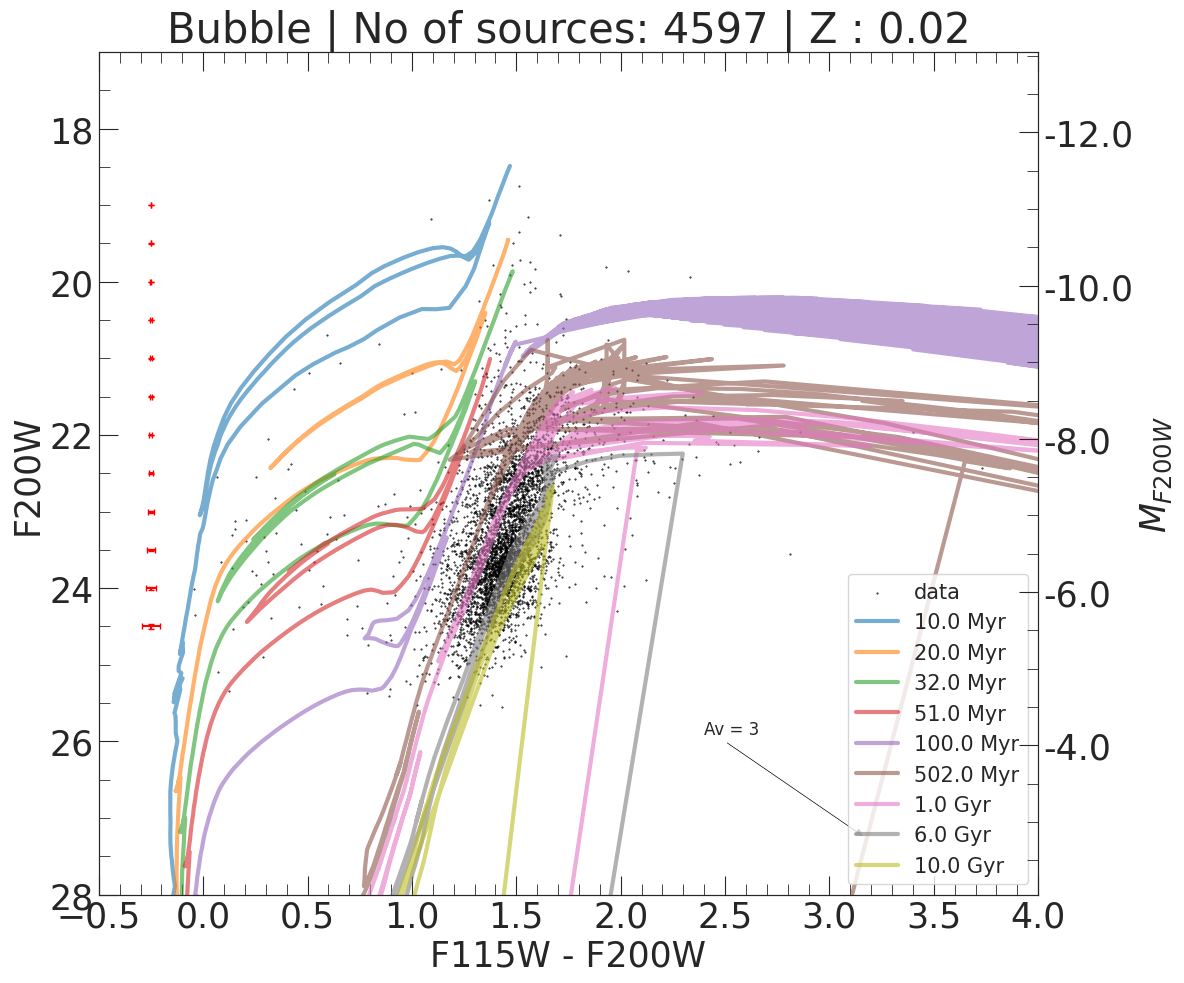

In [198]:
r_in = 0
r_out = 10


fig,ax = gen_CMD('f115w', 'f200w', cmd=df_cmd_jwst, r=None, Av_=3, Av_x=2.5, Av_y=26, xlims=[-0.5,4], ylims=[17,28],
                 out_dir='PHOT_OUTPUT_r25',gen_kde=False, label=9, met=0.02,
                 r_in=r_in, r_out=r_out,
                regions=['bubble'])

### **Extinction Vector**

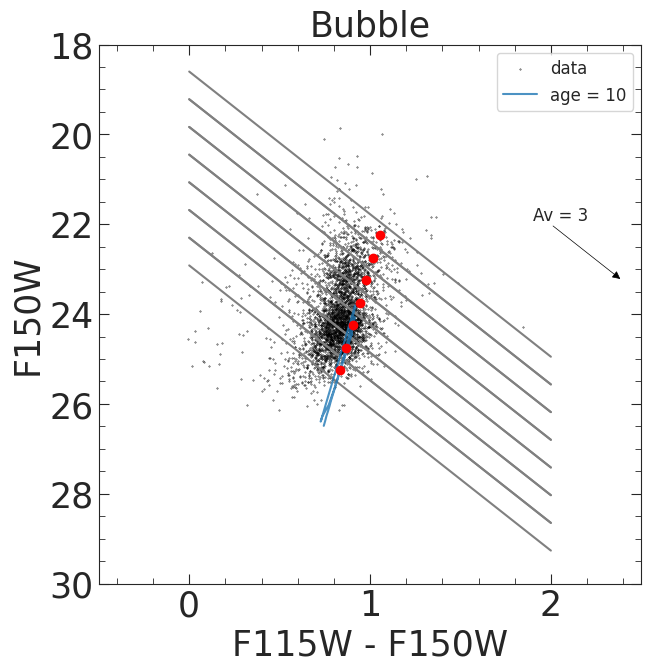

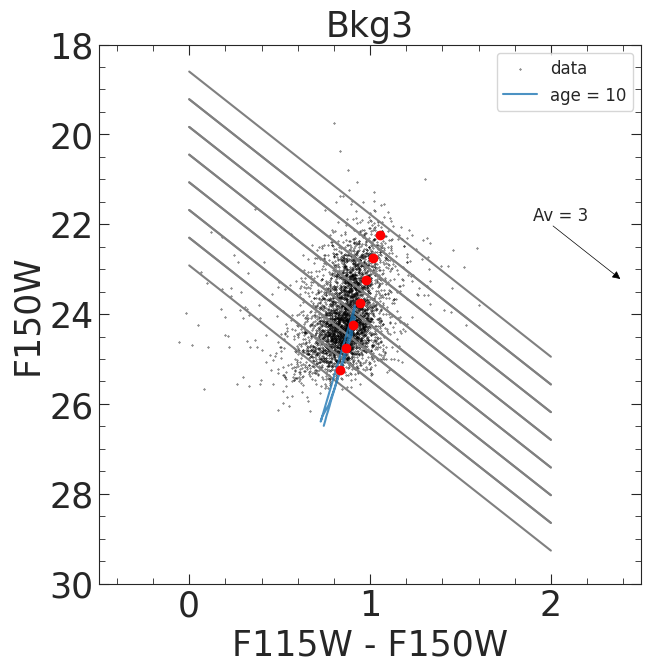

In [184]:
filt1 = 'f115w'
filt2 = 'f150w'
r_in  = 0/0.031367192383255325
r_out = 8/0.031367192383255325

x_cen = 0.5*50/0.031367192383255325
y_cen = 0.5*50/0.031367192383255325
dl= 0.5

l_lo = 22
l_hi = 26
cmd_xlo = 0.4
cmd_xhi = 0.95
fig, ax, dats_bub, x_val, y_val, y_bins = gen_CMD_xcut(filt1, filt2, cmd=df_cmd_jwst, 
                                                      r_in=r_in, r_out=r_out, age=10, met=0.008,
                                                      x_cen=x_cen, y_cen=y_cen,
                                                      l_lo=l_lo, l_hi=l_hi, out_dir='PHOT_OUTPUT_r50',
                                                      dl=dl,flag=111,cmd_xlo=cmd_xlo, cmd_xhi=cmd_xhi,
                                                     fit_isochrone=True)


fig, ax, dats_bkg3, x_val, y_val, y_bins = gen_CMD_xcut(filt1, filt2, cmd=df_cmd_jwst,
                                                       r_in=r_in, r_out=r_out, age=10, met=0.008,
                                                      x_cen=x_cen, y_cen=y_cen,
                                                       l_lo=l_lo, l_hi=l_hi,out_dir='PHOT_OUTPUT_r50',
                                                      dl=dl,flag=111,cmd_xlo=cmd_xlo, cmd_xhi=cmd_xhi,
                                                         inp='bkg3',fit_isochrone=True)

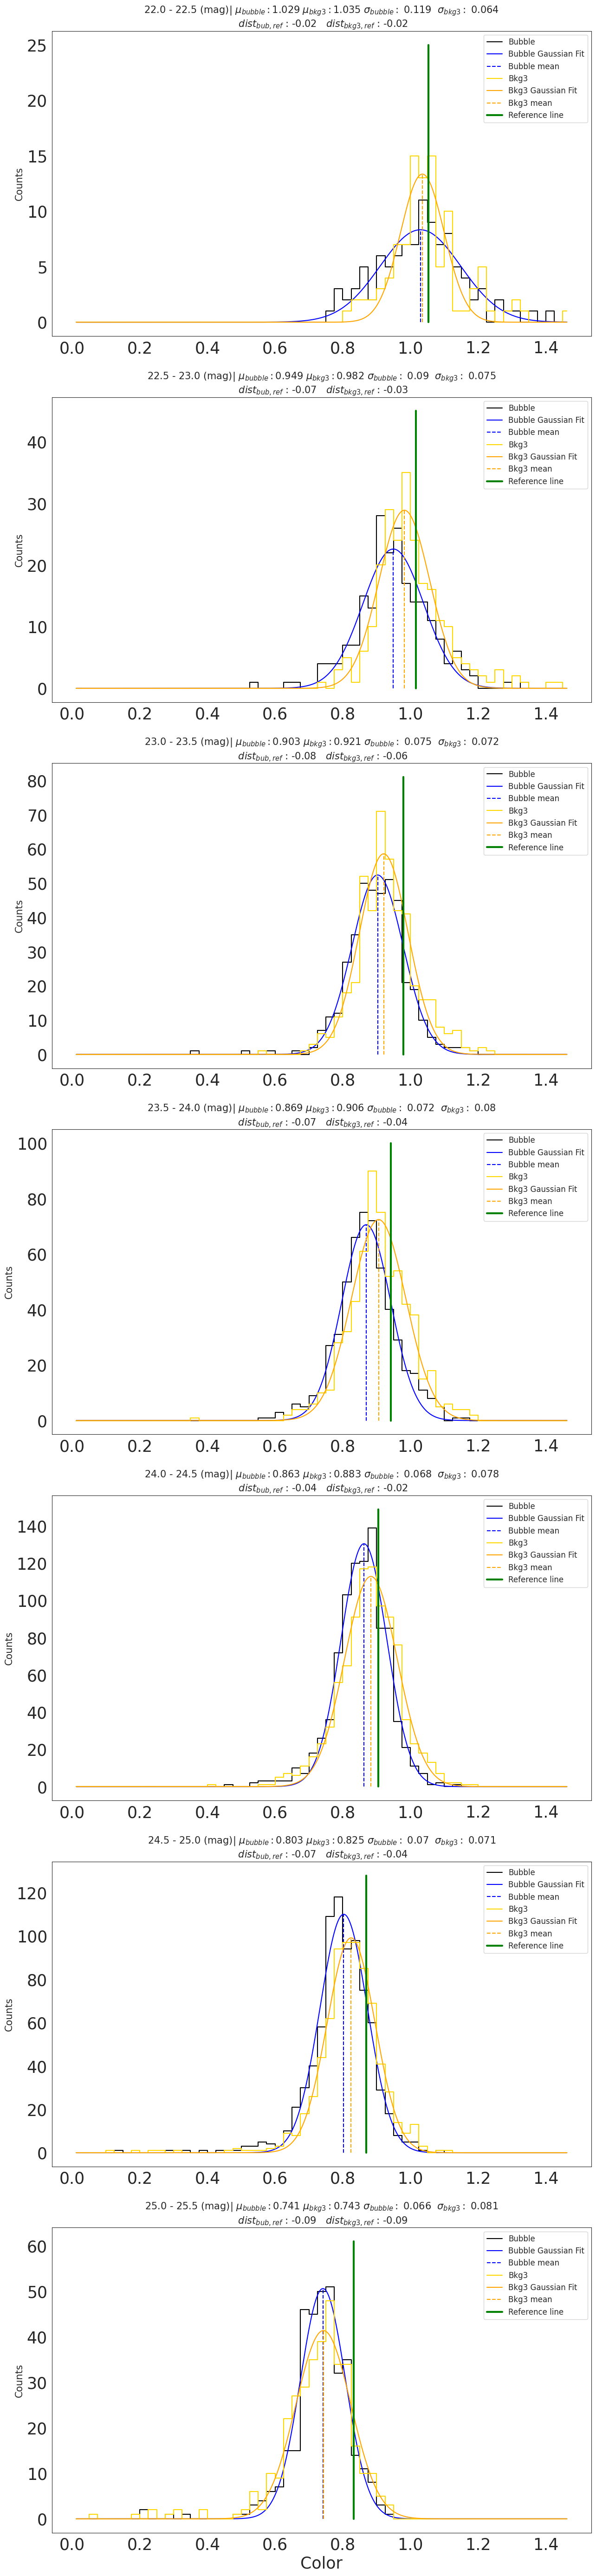

In [185]:
min_ = 0.
max_ = 1.5
step = 0.025
bins = np.arange(min_, max_, step)

fig, ax = plt.subplots(len(y_bins)-1,1,figsize=(15, 10*(len(y_val))), sharex=False)

init = models.Gaussian1D()
fit = fitting.LevMarLSQFitter()

for i in range(len(y_val)):
    
    dat1 = dats_bub[i][0]
    dat2 = dats_bkg3[i][0]

   # Bubble
    y, x = np.histogram(dat1, bins=bins)
    max_bub = y.max()
    
    x = 0.5*(x[1:] + x[:-1])
    
    ax[i].step(x,y, where='mid', color='black')
    
    model = fit(init,x,y)
    xn = np.linspace(x.min(),x.max(),1000)
    
    ax[i].plot(xn,model(xn),'-b')
    
    x_p1 = model.mean.value
    s_p1 = model.stddev.value
    ax[i].plot([x_p1, x_p1],[0,model.amplitude.value], '--b')
    
    
    # Bkg3
    y, x = np.histogram(dat2, bins=bins)
    
    max_bkg3 = y.max()
    
    x = 0.5*(x[1:] + x[:-1])
    
    ax[i].step(x,y, where='mid', color='gold')
    
    model = fit(init,x,y)
    xn = np.linspace(x.min(),x.max(),1000)
    ax[i].plot(xn,model(xn),'-', color='orange')
    
    x_p3 = model.mean.value
    s_p3 = model.stddev.value
    ax[i].plot([x_p3, x_p3],[0,model.amplitude.value], '--', color='orange')
    
    max_ = np.max([max_bub,  max_bkg3])
    
    
    ax[i].plot([x_val[i], x_val[i]], [0, max_+10],'-g',linewidth=3)
    title = f"{np.round(y_bins[i],1)} - {np.round(y_bins[i+1],1)} (mag)| "
    title += r"$\mu_{bubble} :$" + f"{np.round(x_p1,3)}" + r" $\mu_{bkg3} :$" + f"{np.round(x_p3,3)} " 
    
    title += r'$\sigma_{bubble} : $ ' + f"{np.round(s_p1,3)} " + r' $\sigma_{bkg3} : $ ' + f"{np.round(s_p3,3)}\n"
    title +=  r"$\ dist_{bub,ref}$ : " + f"{np.round(x_p1 - x_val[i],2)}  " 
    title +=   r"$\ dist_{bkg3,ref}$ : " + f"{np.round(x_p3 - x_val[i],2)}"
    
    ax[i].set_title(title, fontsize=15)
    ax[i].set_ylabel('Counts', fontsize=15)
    ax[i].legend(['Bubble', 'Bubble Gaussian Fit', 'Bubble mean', 'Bkg3', 'Bkg3 Gaussian Fit', 'Bkg3 mean',
                 'Reference line'])
    
ax[i].set_xlabel('Color');

## **TRGB**

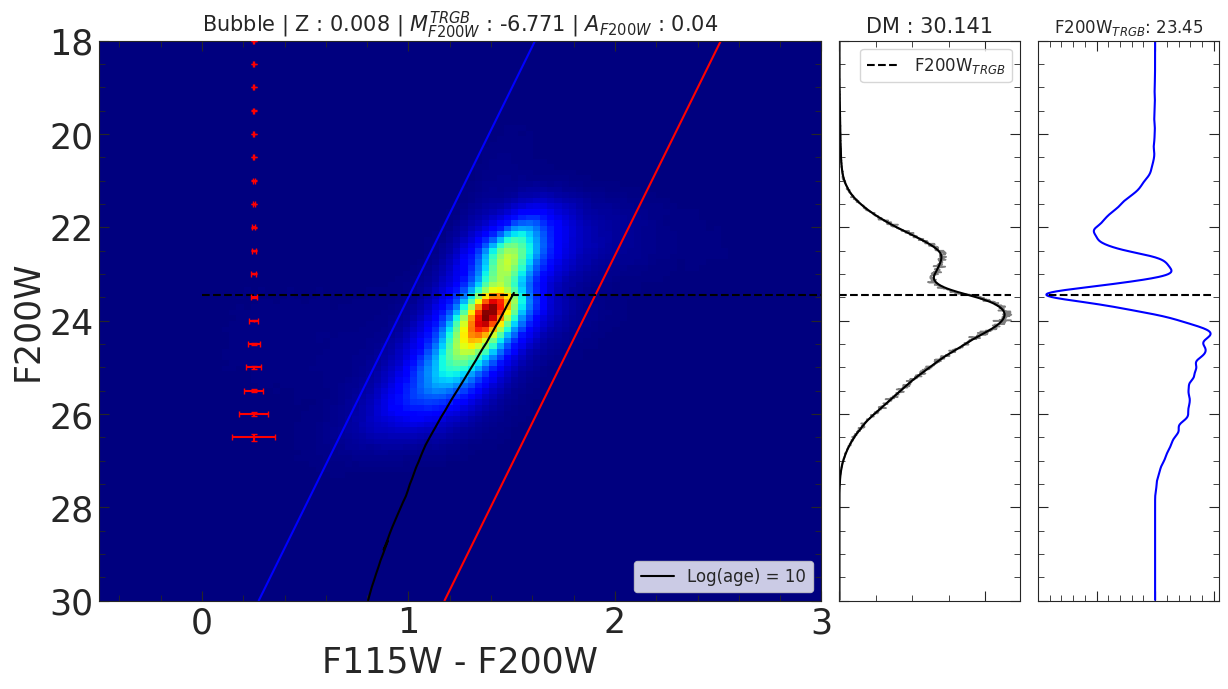

In [28]:
filt1 = 'f115w'
filt2 = 'f200w'
r_in  = 0/0.031367192383255325
r_out = 25/0.031367192383255325

x_cen = 0.5*50/0.031367192383255325
y_cen = 0.5*50/0.031367192383255325
dl= 0.9

l_lo = 18
l_hi = 30
cmd_xlo = 1.0
cmd_xhi = 2.1

fig = plt.figure(figsize=(14, 7))
gs = fig.add_gridspec(1, 3,  width_ratios=(4, 1,1),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax =  fig.add_subplot(gs[0, 0])

fig, ax, dats_bub, x_val, y_val, y_bins = gen_CMD_ycut(filt1, filt2, cmd=df_cmd_jwst, 
                                                      r=None, label=3,
                                                      x_cen=x_cen, y_cen=y_cen, met=0.008,
                                                       age=10, fig=fig, ax=ax, gen_kde=True,
                                                      l_lo=l_lo, l_hi=l_hi, out_dir='PHOT_OUTPUT_r40.5',
                                                      dl=dl,flag=111,cmd_xlo=cmd_xlo, cmd_xhi=cmd_xhi,
                                                       xlims=[-0.5,3], y0=23.5,
                                                      fit_isochrone=True,
                                                      region='Bubble', 
                                                       dismod=30.141)

ax_hist = fig.add_subplot(gs[0, 1], sharey=ax)
ax_edge = fig.add_subplot(gs[0, 2], sharey=ax)

bins = np.arange(l_lo, l_hi,0.01)
for dat in dats_bub:
    x = dat[0]
    y = dat[1]

    yh,xh,_, = ax_hist.hist(y,bins, orientation='horizontal' , histtype='step', color='grey')
    xh = 0.5*(xh[1:] + xh[:-1])
    yf = gaussian_filter(savgol_filter(yh,3,2),10)
    
    ysob = sobel(yf)
    ax_hist.plot(yf, xh, color='black')
    ax_edge.plot(ysob, xh,'b')
    m = xh[ysob==ysob.max()][0]
    
    ax_hist.tick_params(axis="y", labelleft=False)
    ax_edge.tick_params(axis="x", labelbottom=False)
    ax_edge.tick_params(axis="y", labelleft=False)
    
    ax_edge.set_title(f'{filt2.upper()}'+ '$_{TRGB}$' f': {np.round(m,2)}', fontsize=12)
    ax.plot([0,3],[m,m],'--k', zorder=201)
    ax_hist.plot([0,yh.max()],[m,m],'--k',label=f'{filt2.upper()}'+ '$_{TRGB}$')
    ax_hist.legend()
    ax_hist.set_xticks([100],[100])
    ax_hist.tick_params(axis='both', labelsize=15)
    ax_hist.set_title('DM : 30.141', fontsize=15)
    ax_edge.plot([ysob.min(),ysob.max()],[m,m],'--k')
    ax_edge.invert_xaxis()
    
    for ax_ in [ax_hist, ax_edge]:
        ax_.xaxis.set_major_locator(AutoLocator())
        ax_.xaxis.set_minor_locator(AutoMinorLocator())

        ax_.yaxis.set_major_locator(AutoLocator())
        ax_.yaxis.set_minor_locator(AutoMinorLocator())

        ax_.tick_params(which='both', length=7,direction="in", bottom=True, top=True,left=True, right=True)
        ax_.tick_params(which='minor', length=4)


In [29]:
23.45 + 6.771 -0.04

30.181

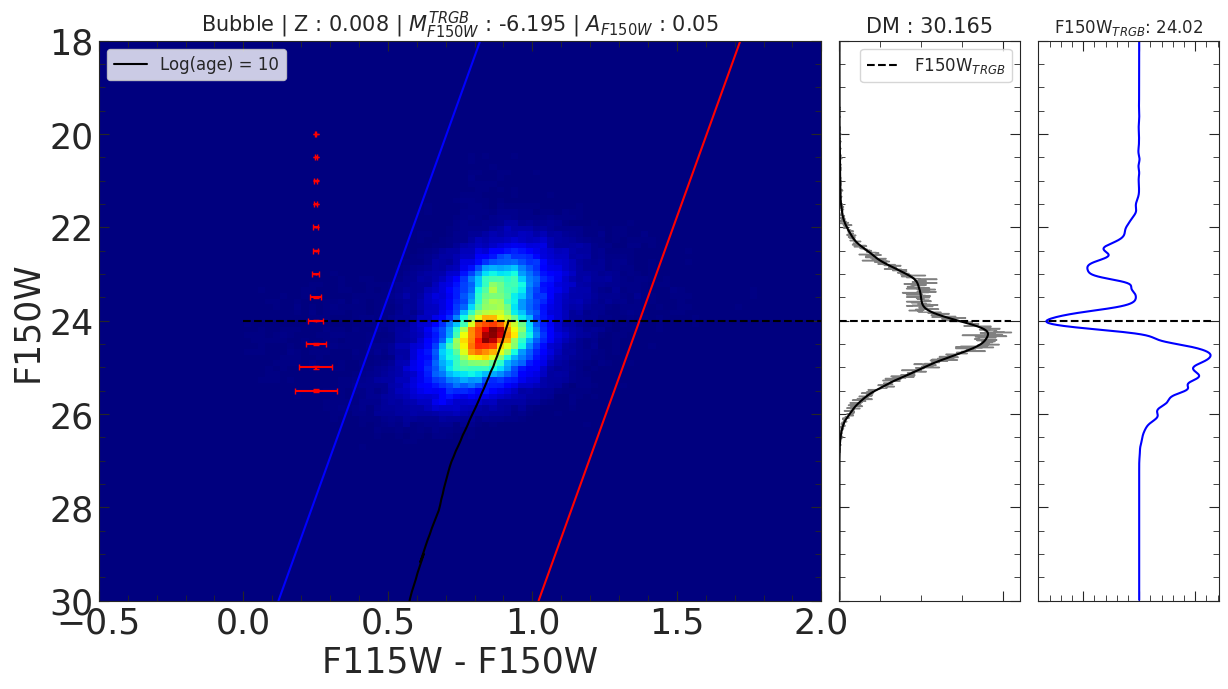

In [209]:
filt1 = 'f115w'
filt2 = 'f150w'
r_in  = 0/0.03087613811252988
r_out = 25/0.03087613811252988

x_cen = 0.5*50/0.03087613811252988
y_cen = 0.5*50/0.03087613811252988
dl= 0.9

l_lo = 18
l_hi = 30
cmd_xlo = 0.5
cmd_xhi = 2.1

fig = plt.figure(figsize=(14, 7))
gs = fig.add_gridspec(1, 3,  width_ratios=(4, 1,1),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax =  fig.add_subplot(gs[0, 0])

fig, ax, dats_bub, x_val, y_val, y_bins = gen_CMD_ycut(filt1, filt2, cmd=df_cmd_jwst, 
                                                      r_in=r_in, r_out=r_out, label=3,
                                                      x_cen=x_cen, y_cen=y_cen, met= 0.008,
                                                       age=10, fig=fig, ax=ax, gen_kde=True,
                                                      l_lo=l_lo, l_hi=l_hi, out_dir='PHOT_OUTPUT_r50',
                                                      dl=dl,flag=111,cmd_xlo=cmd_xlo, cmd_xhi=cmd_xhi,
                                                       xlims=[-0.5,2], y0=23.5,
                                                      fit_isochrone=True,
                                                      region='Bubble', 
                                                       dismod=30.141)

ax_hist = fig.add_subplot(gs[0, 1], sharey=ax)
ax_edge = fig.add_subplot(gs[0, 2], sharey=ax)

bins = np.arange(l_lo, l_hi,0.01)
for dat in dats_bub:
    x = dat[0]
    y = dat[1]

    yh,xh,_, = ax_hist.hist(y,bins, orientation='horizontal' , histtype='step', color='grey')
    xh = 0.5*(xh[1:] + xh[:-1])
    yf = gaussian_filter(savgol_filter(yh,3,2),10)
    
    ysob = sobel(yf)
    ax_hist.plot(yf, xh, color='black')
    ax_edge.plot(ysob, xh,'b')
    m = xh[ysob==ysob.max()][0]
    
    ax_hist.tick_params(axis="y", labelleft=False)
    ax_edge.tick_params(axis="x", labelbottom=False)
    ax_edge.tick_params(axis="y", labelleft=False)
    
    ax_edge.set_title(f'{filt2.upper()}'+ '$_{TRGB}$' f': {np.round(m,2)}', fontsize=12)
    ax.plot([0,3],[m,m],'--k', zorder=201)
    ax_hist.plot([0,yh.max()],[m,m],'--k',label=f'{filt2.upper()}'+ '$_{TRGB}$')
    ax_hist.legend()
    ax_hist.set_xticks([100],[100])
    ax_hist.tick_params(axis='both', labelsize=15)
    ax_hist.set_title('DM : 30.165', fontsize=15)
    ax_edge.plot([ysob.min(),ysob.max()],[m,m],'--k')
    ax_edge.invert_xaxis()
    
    for ax_ in [ax_hist, ax_edge]:
        ax_.xaxis.set_major_locator(AutoLocator())
        ax_.xaxis.set_minor_locator(AutoMinorLocator())

        ax_.yaxis.set_major_locator(AutoLocator())
        ax_.yaxis.set_minor_locator(AutoMinorLocator())

        ax_.tick_params(which='both', length=7,direction="in", bottom=True, top=True,left=True, right=True)
        ax_.tick_params(which='minor', length=4)


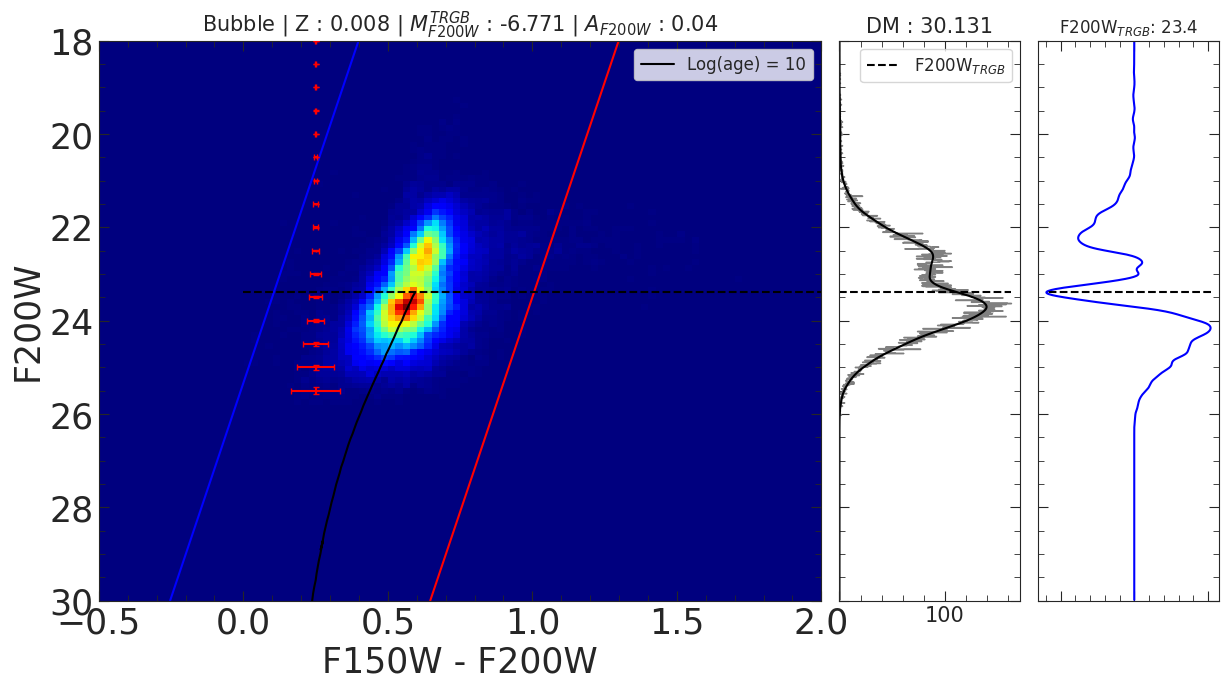

In [213]:
filt1 = 'f150w'
filt2 = 'f200w'
r_in  = 0/0.03087613811252988
r_out = 25/0.03087613811252988

x_cen = 0.5*50/0.03087613811252988
y_cen = 0.5*50/0.03087613811252988
dl= 0.9

l_lo = 18
l_hi = 30
cmd_xlo = 0.1
cmd_xhi = 1.1

fig = plt.figure(figsize=(14, 7))
gs = fig.add_gridspec(1, 3,  width_ratios=(4, 1,1),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax =  fig.add_subplot(gs[0, 0])

fig, ax, dats_bub, x_val, y_val, y_bins = gen_CMD_ycut(filt1, filt2, cmd=df_cmd_jwst, 
                                                      r_in=r_in, r_out=r_out, label=3,
                                                      x_cen=x_cen, y_cen=y_cen, met= 0.008,
                                                       age=10, fig=fig, ax=ax, gen_kde=True,
                                                      l_lo=l_lo, l_hi=l_hi, out_dir='PHOT_OUTPUT_r50',
                                                      dl=dl,flag=111,cmd_xlo=cmd_xlo, cmd_xhi=cmd_xhi,
                                                       xlims=[-0.5,2], y0=23.5,
                                                      fit_isochrone=True,
                                                      region='Bubble', 
                                                       dismod=30.141)

ax_hist = fig.add_subplot(gs[0, 1], sharey=ax)
ax_edge = fig.add_subplot(gs[0, 2], sharey=ax)

bins = np.arange(l_lo, l_hi,0.01)
for dat in dats_bub:
    x = dat[0]
    y = dat[1]

    yh,xh,_, = ax_hist.hist(y,bins, orientation='horizontal' , histtype='step', color='grey')
    xh = 0.5*(xh[1:] + xh[:-1])
    yf = gaussian_filter(savgol_filter(yh,3,2),10)
    
    ysob = sobel(yf)
    ax_hist.plot(yf, xh, color='black')
    ax_edge.plot(ysob, xh,'b')
    m = xh[ysob==ysob.max()][0]
    
    ax_hist.tick_params(axis="y", labelleft=False)
    ax_edge.tick_params(axis="x", labelbottom=False)
    ax_edge.tick_params(axis="y", labelleft=False)
    
    ax_edge.set_title(f'{filt2.upper()}'+ '$_{TRGB}$' f': {np.round(m,2)}', fontsize=12)
    ax.plot([0,3],[m,m],'--k', zorder=201)
    ax_hist.plot([0,yh.max()],[m,m],'--k',label=f'{filt2.upper()}'+ '$_{TRGB}$')
    ax_hist.legend()
    ax_hist.set_xticks([100],[100])
    ax_hist.tick_params(axis='both', labelsize=15)
    ax_hist.set_title('DM : 30.131', fontsize=15)
    ax_edge.plot([ysob.min(),ysob.max()],[m,m],'--k')
    ax_edge.invert_xaxis()
    
    for ax_ in [ax_hist, ax_edge]:
        ax_.xaxis.set_major_locator(AutoLocator())
        ax_.xaxis.set_minor_locator(AutoMinorLocator())

        ax_.yaxis.set_major_locator(AutoLocator())
        ax_.yaxis.set_minor_locator(AutoMinorLocator())

        ax_.tick_params(which='both', length=7,direction="in", bottom=True, top=True,left=True, right=True)
        ax_.tick_params(which='minor', length=4)


## **Carbon Stars**

In [16]:
tab = Table.read('../PHOT_OUTPUT_r40.5/galaxy/f115w_f200w.fits')

In [18]:
tab['f115w_f200w'] = tab['mag_vega_F115W'] - tab['mag_vega_F200W']

x = np.linspace(1,4)
y = (24-29)*(x-2.1) + 24

init = models.Linear1D()
fit = fitting.LinearLSQFitter()
model_1 = fit(init, x,y)

y = -(24-24.2)*(x-2.5) + 24

model_2 = fit(init, x,y)

ra_cen, dec_cen = 24.1739654, 15.7837025

tab['r'] = angular_separation(tab['ra_1']*u.deg, tab['dec_1']*u.deg, ra_cen*u.deg, dec_cen*u.deg).to(u.arcsec).value

x = tab['ra_1']
y = tab['dec_1']
c = tab['r']

rs = [0, 10]
A  = np.pi*rs[-1]**2

while rs[-1] < 75:
    r = np.sqrt((A+np.pi*rs[-1]**2)/np.pi)
    
    rs.append(r)
    
n_cs = [0]
for i in range(len(rs)-1):
    r_in = rs[i]
    r_out = rs[i+1]
    
    # Annulus
    t = tab[(tab['r']>=r_in) & (tab['r']<r_out)]
    
    # Carbon stars
    t = t[t['mag_vega_F200W']>=model_1(t['f115w_f200w'])]
    t = t[t['mag_vega_F200W']<=model_2(t['f115w_f200w'])]
    
    x = t['ra_1']
    y = t['dec_1']
    
    n_cs.append(len(t))

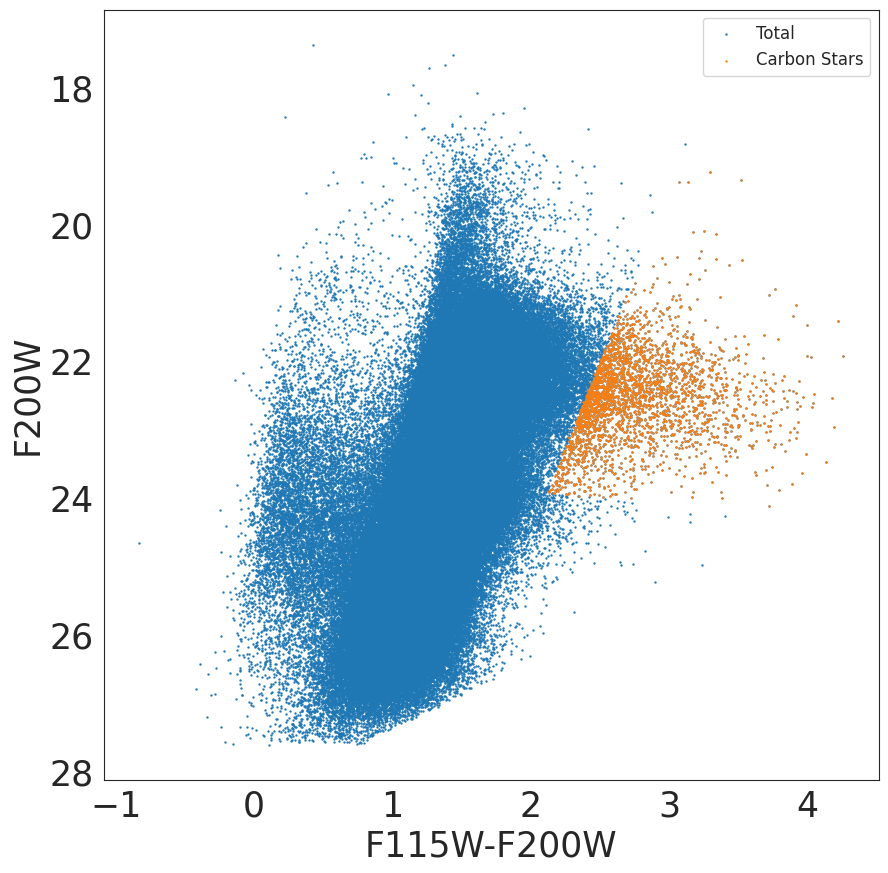

In [32]:

fig, ax = plt.subplots()

x = tab['f115w_f200w']
y = tab['mag_vega_F200W']
ax.scatter(x,y, s=0.5)

x = t['f115w_f200w']
y = t['mag_vega_F200W']


ax.scatter(x,y, s=0.5)
ax.invert_yaxis()
ax.set_xlabel('F115W-F200W')
ax.set_ylabel('F200W')

ax.legend(['Total','Carbon Stars'])

Text(0, 0.5, 'No of Carbon stars')

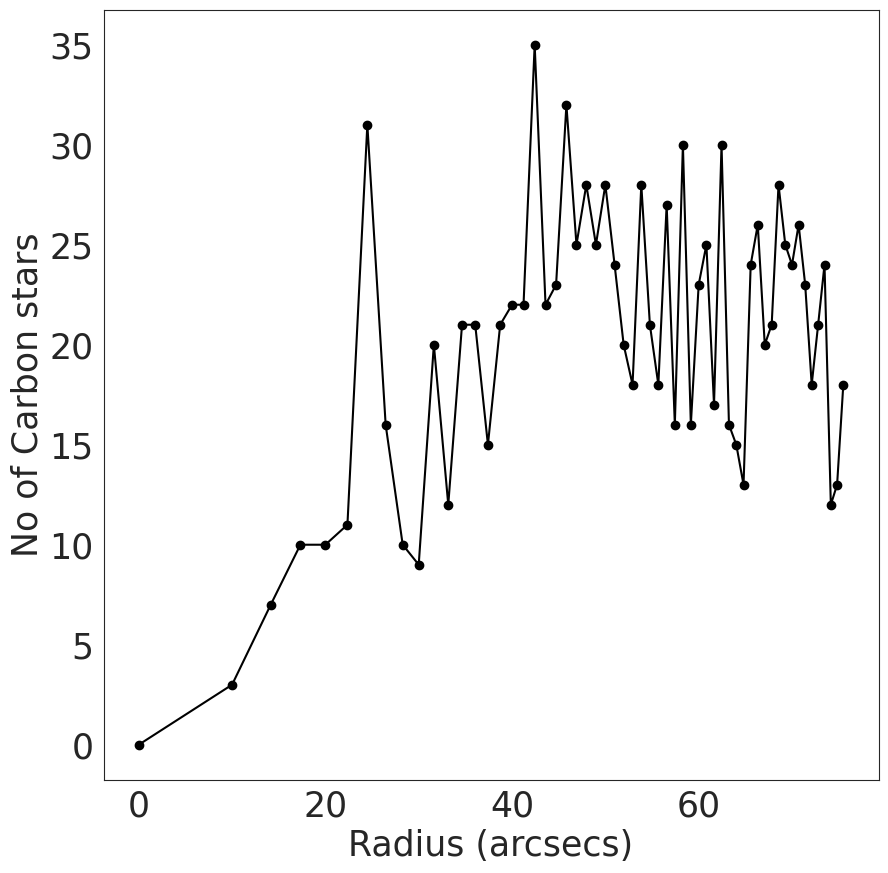

In [19]:
x = rs
y = n_cs

plt.plot(x,y,'-ok')
plt.xlabel('Radius (arcsecs)')
plt.ylabel('No of Carbon stars')

Text(0, 0.5, 'Dec (deg)')

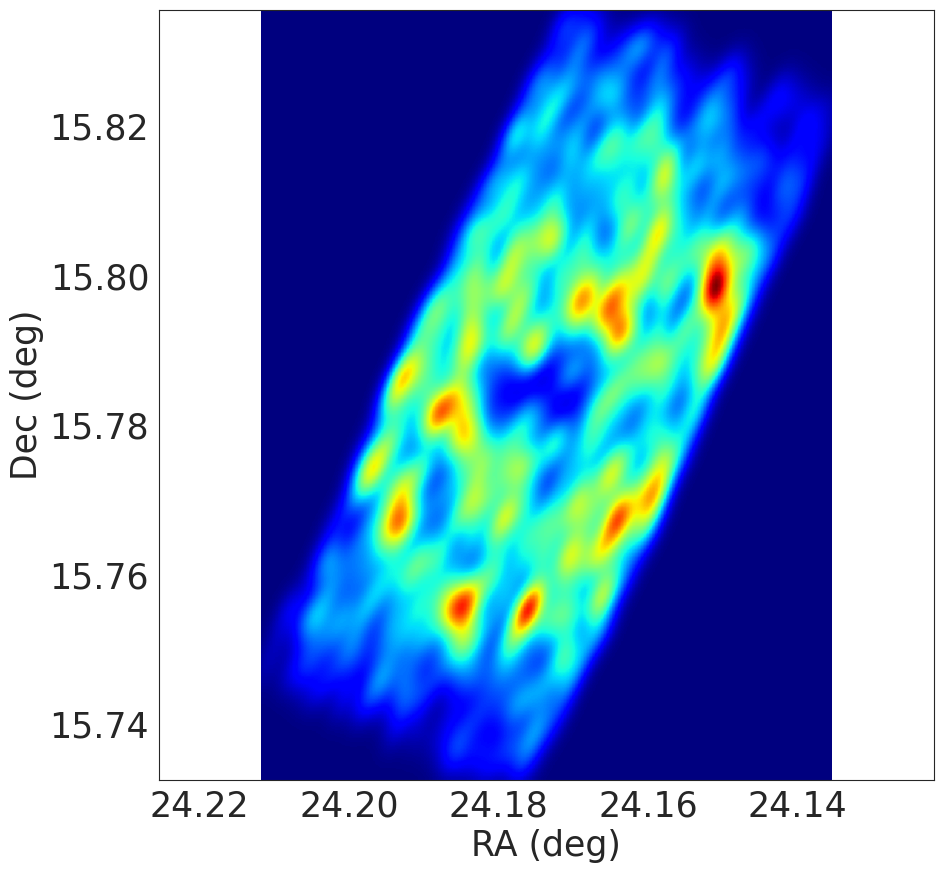

In [35]:
t = tab

# Carbon stars
t = t[t['mag_vega_F200W']>=model_1(t['f115w_f200w'])]
t = t[t['mag_vega_F200W']<=model_2(t['f115w_f200w'])]

fig, ax = plt.subplots()

x = t['ra_1']
y = t['dec_1']

xmin, xmax = x.min()-2/3600,  x.max() + 2/3600
ymin, ymax = y.min()-2/3600,  y.max() + 2/3600

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:200j, ymin:ymax:200j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])

kernel = gaussian_kde(values, bw_method=0.1)
f = np.reshape(kernel(positions), xx.shape)

f = np.fliplr(f).T

img = ax.imshow(f, cmap='jet', 
          extent=[xmax, xmin,
                  ymin, ymax])
ax.axis('equal')
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')

## **HST**

### **PARSEC Isochrones**

#### **ACS/WFC**

In [152]:
with open("../data/isochrones_master/cmd_hst_acs.dat") as f:
    dat = f.readlines()

data = []

for i,d in enumerate(dat[13:-1]):
    if 'Zini' not in d:
        data.append([float(i) for i in d.split()])
        
df_cmd_acs = pd.DataFrame(data,columns=dat[13][2:].split())[:-1]
df_cmd_acs = df_cmd_acs[df_cmd_acs['Zini']==0.02]
df_cmd_acs.to_csv("../data/isochrones_master/cmd_hst_acs.csv", index=None)

#df_cmd_acs = df_cmd_acs[(df_cmd_acs['label']>-1) & (df_cmd_acs['label']<7)]

In [149]:
df_cmd_acs= pd.read_csv("../data/isochrones_master/cmd_hst_acs.csv")

In [150]:
ages = np.round(np.arange(6.0,8.2,0.1),1)
mets = np.unique(df_cmd_acs['Zini'])
mag_err_lim = 0.2

In [151]:
if not os.path.exists('../data/isochrones/HST_ACS'):
    os.mkdir('../data/isochrones/HST_ACS/')
else:
    os.system('rm ../data/isochrones/HST_ACS/*')
    
for i, age in enumerate(ages):
    if len(str(i+1))==1:
        i = '0' + str(i+1)
    else:
        i =  str(i+1)
    for met in [0.02, 0.008]:
        
        temp = df_cmd_acs[df_cmd_acs['logAge']==age]
        temp = temp[temp['Zini']==met]
        temp = temp[['label', 'Mini', 'F435Wmag', 'F555Wmag', 'F814Wmag', 'Zini', 'logAge']]
        temp =  temp[temp['Mini']>=2]
        header = list(temp.keys())
        header[0] = '#' + header[0]

        temp.to_csv(f'../data/isochrones/HST_ACS/{i}_PARSEC1.1_Z{met}_logAGE{age}Myr_HST_BVI.isoc',sep=' ',
                   index=None, header = header)

#### **WFC3/UVIS**

In [168]:
with open("../data/isochrones_master/cmd_hst_uvis.dat") as f:
    dat = f.readlines()

data = []

for i,d in enumerate(dat[13:-1]):
    if 'Zini' not in d:
        data.append([float(i) for i in d.split()])
        
df_cmd_uvis = pd.DataFrame(data,columns=dat[13][2:].split())[:-1]
df_cmd_uvis.to_csv("../data/isochrones_master/cmd_hst_uvis.csv")
df_cmd_uvis = df_cmd_uvis[df_cmd_uvis['MH']==0.51508]
#df_cmd_uvis = df_cmd_uvis[(df_cmd_uvis['label']>-1) & (df_cmd_uvis['label']<7)]

In [169]:
df_cmd_uvis = pd.read_csv("../data/isochrones_master/cmd_hst_uvis.csv")

In [170]:
ages = np.round(np.arange(6.0,8.1,0.1),1)

mag_err_lim = 0.2

In [171]:
if not os.path.exists('../data/isochrones/HST_UVIS'):
    os.mkdir('../data/isochrones/HST_UVIS/')
else:
    os.system('rm ../data/isochrones/HST_UVIS/*')
    
for i, age in enumerate(ages):
    temp = df_cmd_uvis[df_cmd_uvis['logAge']==age]
    if len(str(i+1))==1:
        i = '0' + str(i+1)
    else:
        i =  str(i+1)
    
    temp = temp[['label', 'Mini', 'F275Wmag', 'F336Wmag', 'Zini', 'logAge']]
    temp =  temp[temp['Mini']>=2]
    header = list(temp.keys())
    header[0] = '#' + header[0]
        
    temp.to_csv(f'../data/isochrones/HST_UVIS/{i}_PARSEC1.1_Z0.015_logAGE{age}Myr_HST_UVIS.isoc',sep=' ',
               index=None, header = header)

### **CMD**

In [172]:
ages_ = np.round(np.log10([7e6, 1e7, 2e7, 3e7, 5e7,1e8,2e8]),1)

In [173]:
age_lin = []
for i in ages_:
    if i > 6  and i <9:
        i-=6
        age_lin.append(f'{np.ceil(10**i)} Myr')
    elif i >= 9:
        i-=9
        age_lin.append(f'{np.ceil(10**i)} Gyr')
        

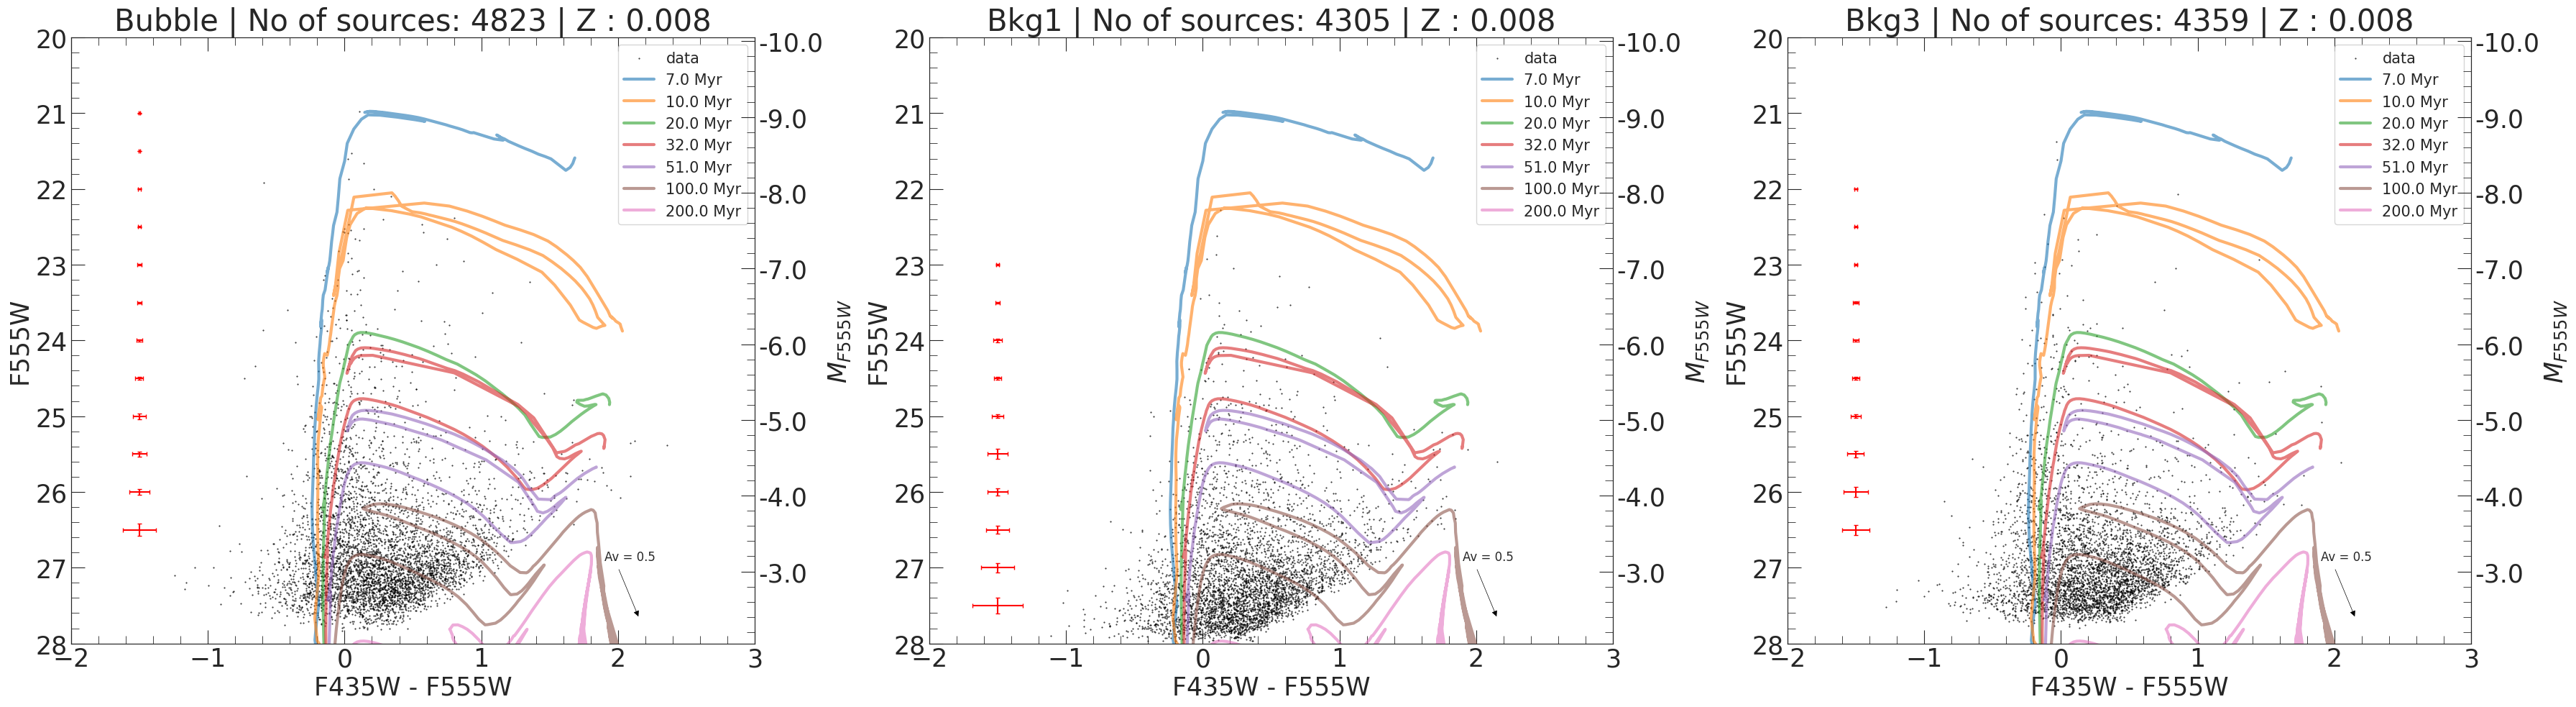

In [174]:
r_in = 0/0.05
r_out = 12/0.05

x_cen = 0.5*25/0.05
y_cen = 0.5*25/0.05

fig, ax = gen_CMD('f435w','f555w', cmd=df_cmd_acs, out_dir='PHOT_OUTPUT_r25',
                 Av_=0.5, xlims=[-2,3], ylims=[20,28], r_in=r_in,r_out=r_out, ref_xpos = -1.5,
                 x_cen=x_cen, y_cen=y_cen, label = 9, met=0.008, regions=['bubble','bkg1','bkg3'],
                 Av_x = 2, Av_y=27,flag=111)

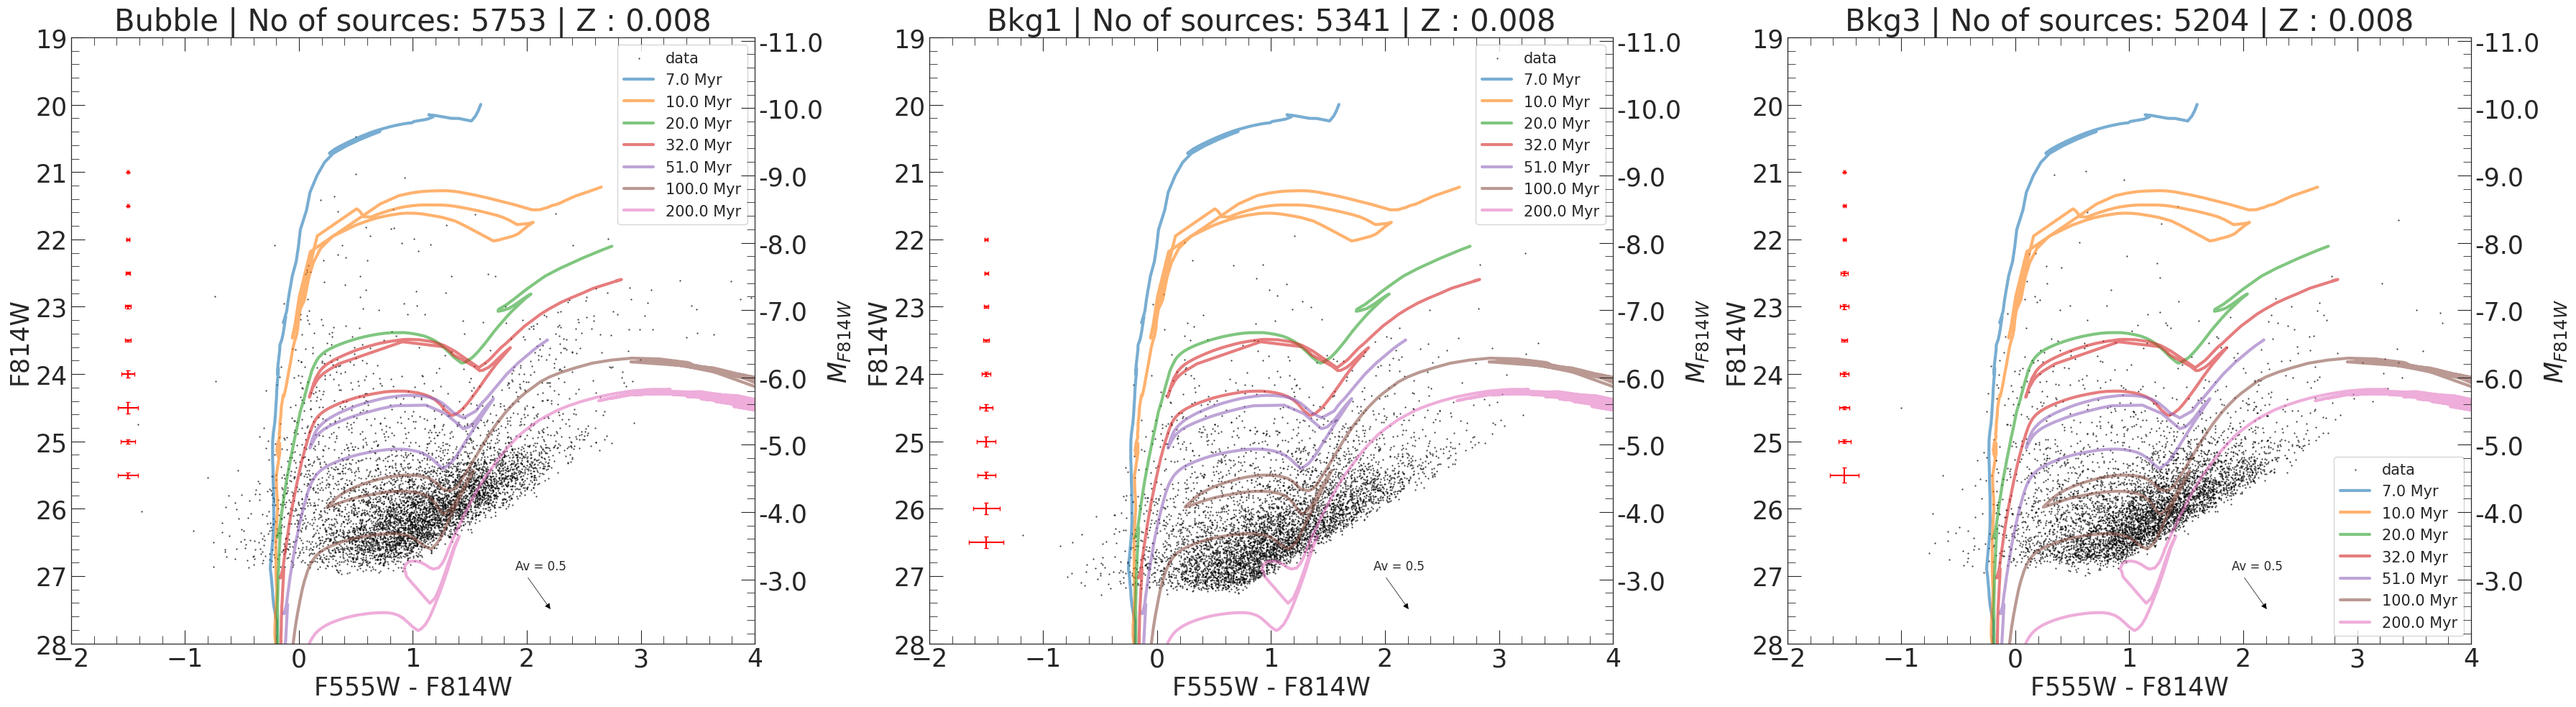

In [159]:
r_in = 0/0.05
r_out = 12/0.05

x_cen = 0.5*25/0.05
y_cen = 0.5*25/0.05

fig, ax = gen_CMD('f555w','f814w', cmd=df_cmd_acs, out_dir='PHOT_OUTPUT_r25',
                 Av_=0.5, xlims=[-2,4], ylims=[19,28], r_in=r_in, r_out=r_out, ref_xpos=-1.5,
                 x_cen=x_cen, y_cen=y_cen, label = 9, met=0.008, regions=['bubble','bkg1','bkg3'],
                 Av_x = 2, Av_y=27,flag=111)

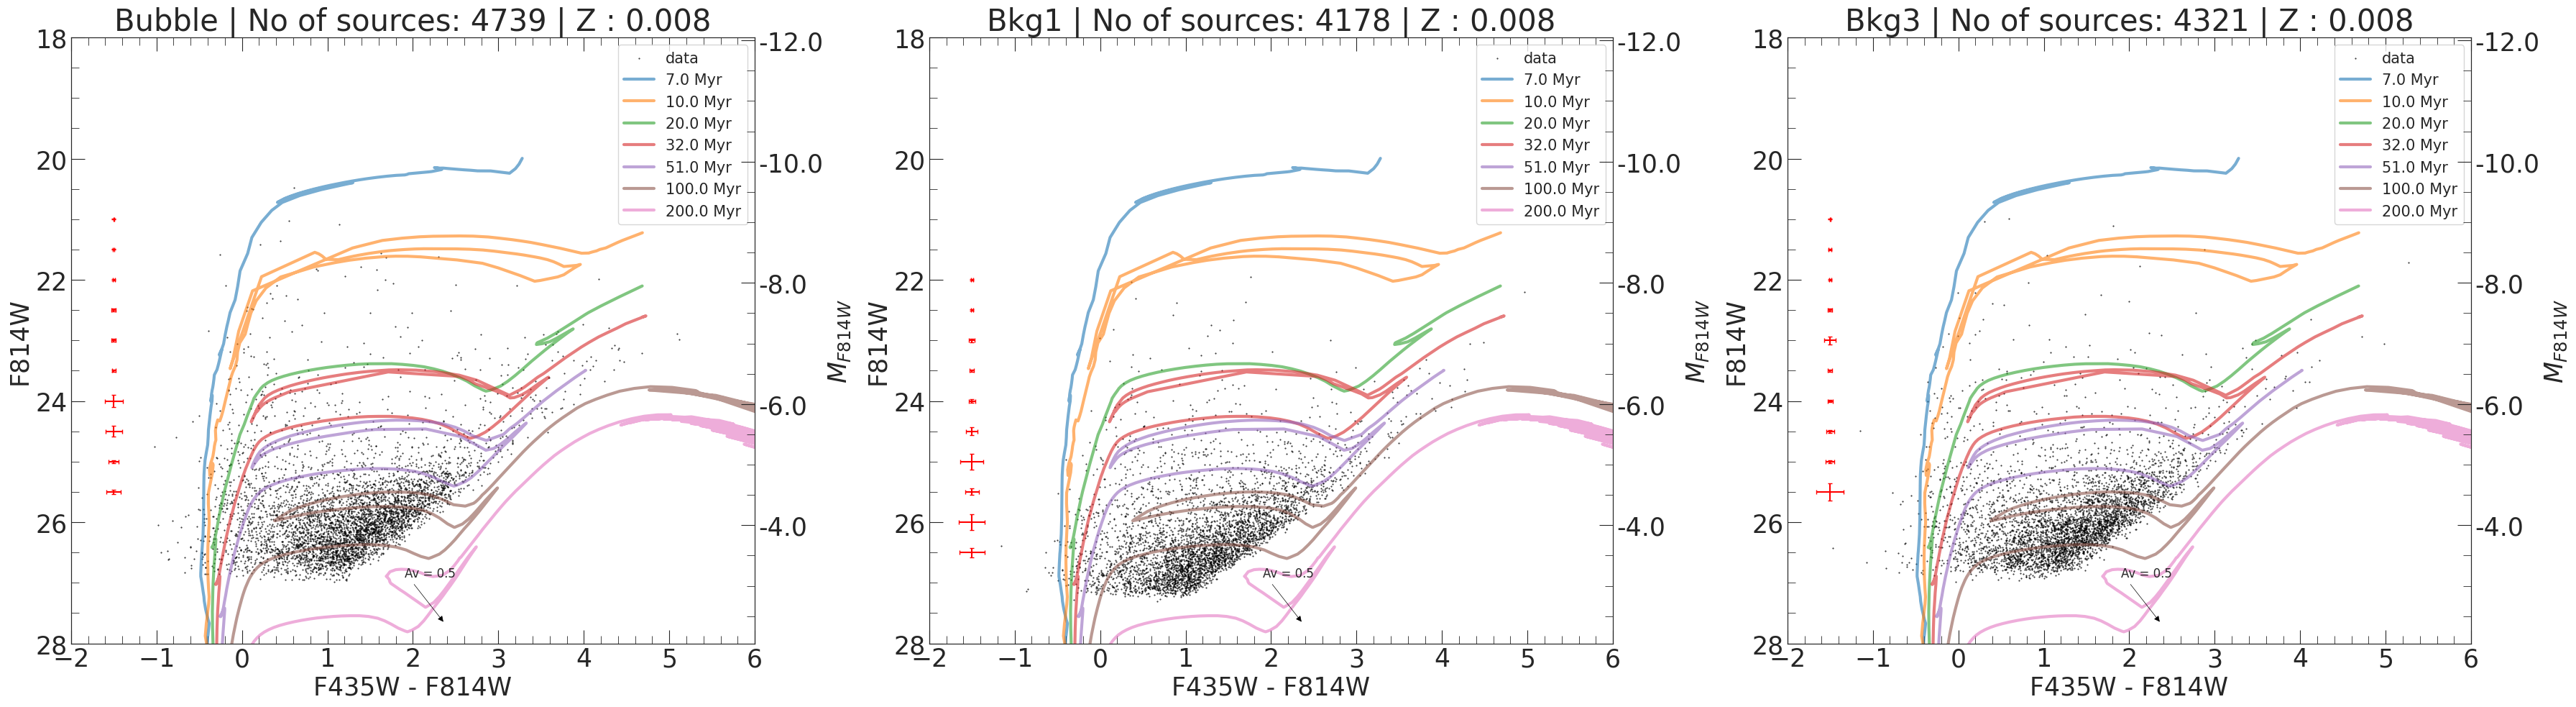

In [161]:
r_in = 0/0.05
r_out = 12/0.05

x_cen = 0.5*25/0.05
y_cen = 0.5*25/0.05
fig, ax = gen_CMD('f435w','f814w', cmd=df_cmd_acs, out_dir='PHOT_OUTPUT_r25',
                 Av_=0.5, xlims=[-2,6], ylims=[18,28], r_in=r_in, r_out=r_out, ref_xpos=-1.5,
                 x_cen=x_cen, y_cen=y_cen,label = 9, met=0.008, regions=['bubble','bkg1','bkg3'],
                 Av_x = 2, Av_y=27,flag=111)

In [162]:
ages_ = np.round(np.log10([4e6, 7e6, 1e7, 2e7, 3e7, 5e7]),1)

In [163]:
ages_

array([6.6, 6.8, 7. , 7.3, 7.5, 7.7])

In [164]:
age_lin = []
for i in ages_:
    if i > 6  and i <9:
        i-=6
        age_lin.append(f'{np.ceil(10**i)} Myr')
    elif i >= 9:
        i-=9
        age_lin.append(f'{np.ceil(10**i)} Gyr')
        

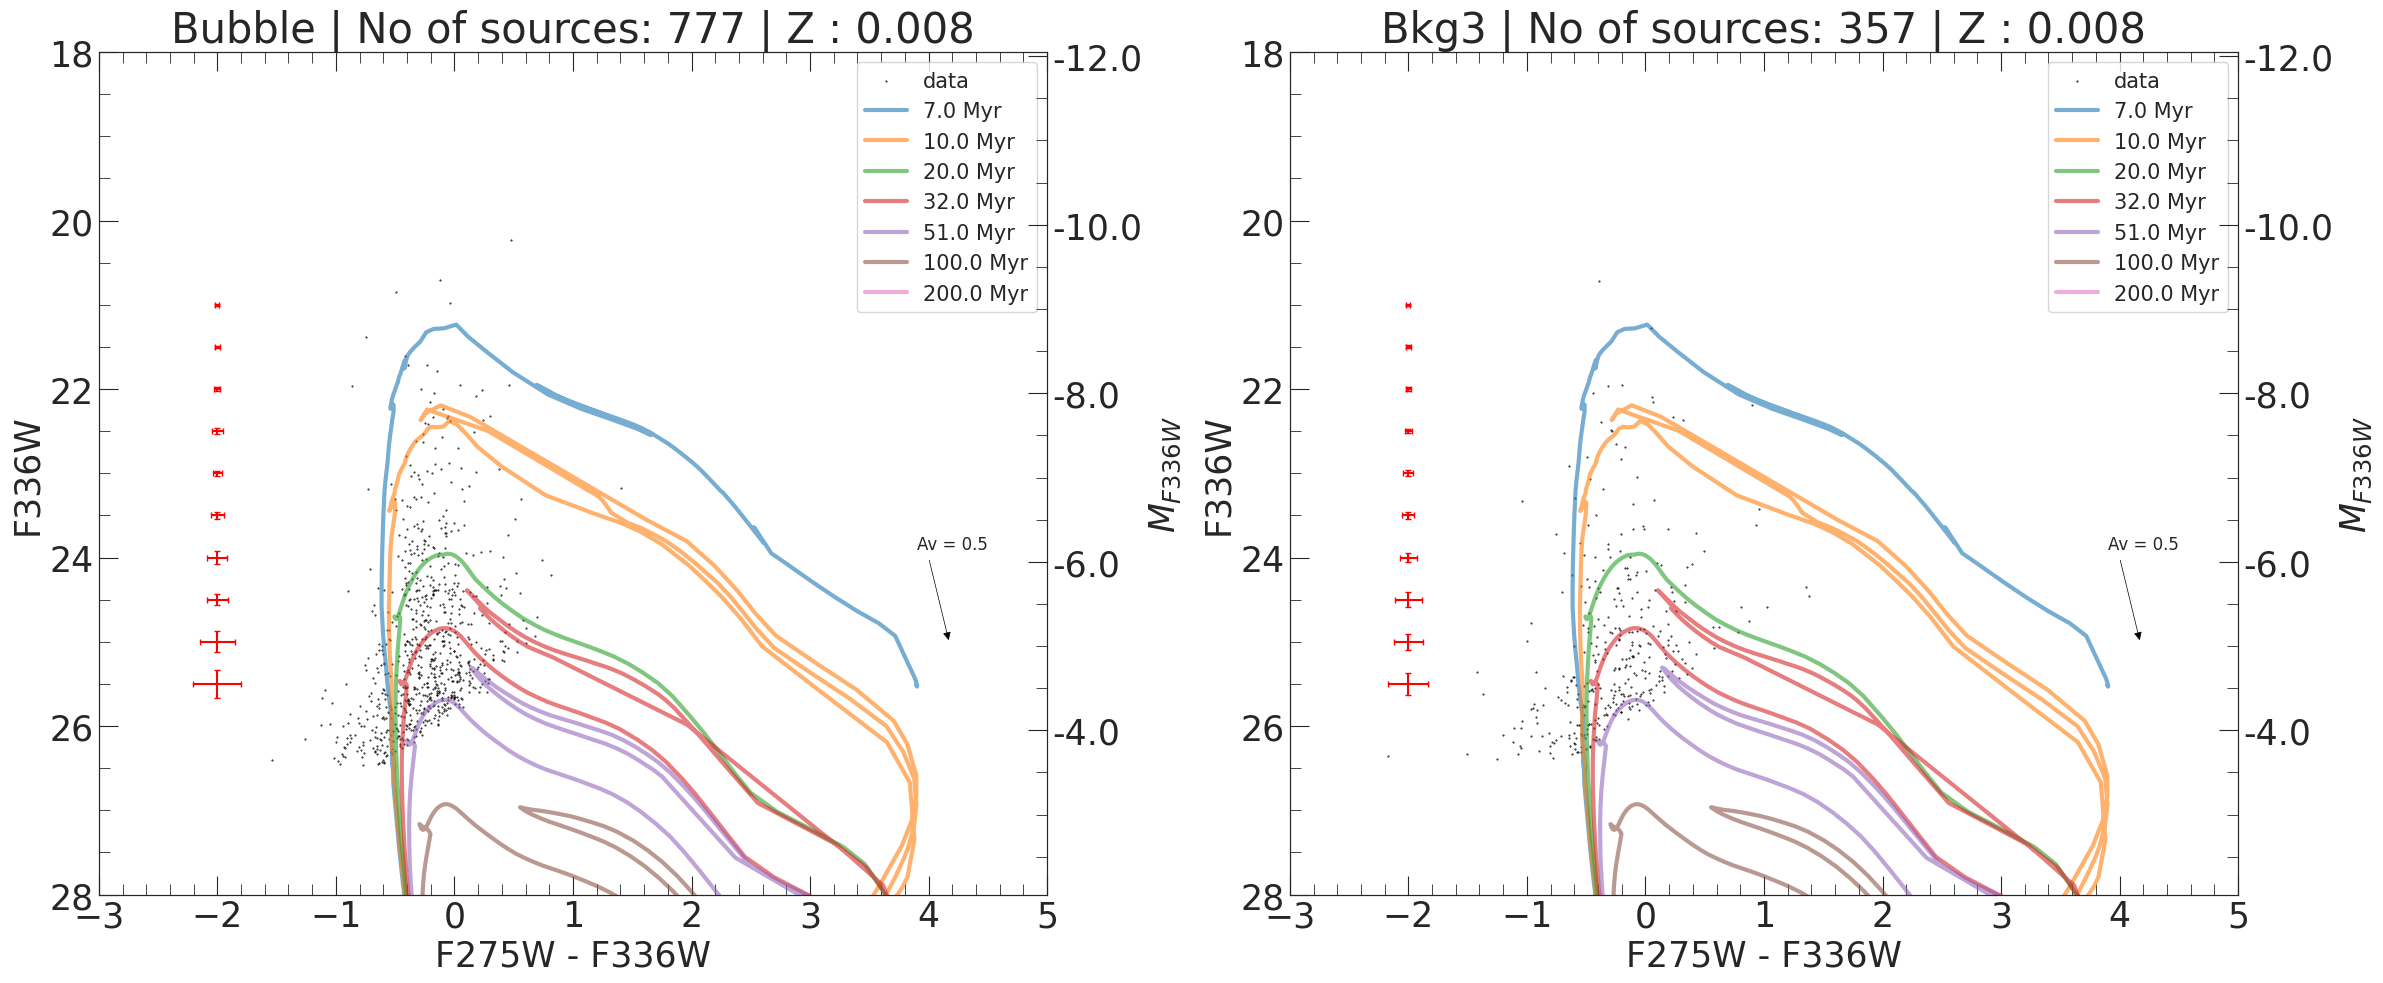

In [178]:
fig, ax = gen_CMD('f275w','f336w', cmd=df_cmd_uvis, out_dir='PHOT_OUTPUT_r25',
                 Av_=0.5, xlims=[-3,5], ylims=[18,28], r=10/0.04, met=0.008,label=9, ref_xpos=-2,
                 x_cen=631/2, y_cen=631/2, regions=['bubble','bkg3'], Av_x=4, Av_y=24,
                 flag=111)

### **Extinction Vector**

In [ ]:
df_cmd_hst['Zini']

## **JWST-HST**

In [242]:
df_cmd_hst_jwst = pd.read_csv('../data/isochrones_master/cmd_jwst_hst.csv')

In [155]:
ages = ages = np.round(np.arange(6.0,9.1,0.1),1)

In [165]:
if not os.path.exists('../data/isochrones/HST_JWST'):
    os.mkdir('../data/isochrones/HST_JWST/')
else:
    os.system('rm ../data/isochrones/HST_JWST/*')
    
for i, age in enumerate(ages):
    temp = df_cmd_hst_jwst[df_cmd_hst_jwst['logAge_1']==age]
    if len(str(i+1))==1:
        i = '0' + str(i+1)
    else:
        i =  str(i+1)
    
    temp = temp[['label_1', 'Mass_1', 'F435Wmag', 'F555Wmag', 'F814Wmag', 'F115Wmag', 'F150Wmag', 'F200Wmag', 'Zini_1', 'logAge_1']]
    header = list(temp.keys())
    header[0] = '#' + header[0]
        
    temp.to_csv(f'../data/isochrones/HST_JWST/{i}_PARSEC1.1_Z0.02_logAGE{age}Myr_JWST_JHK.isoc',sep=' ',
               index=None, header = header)


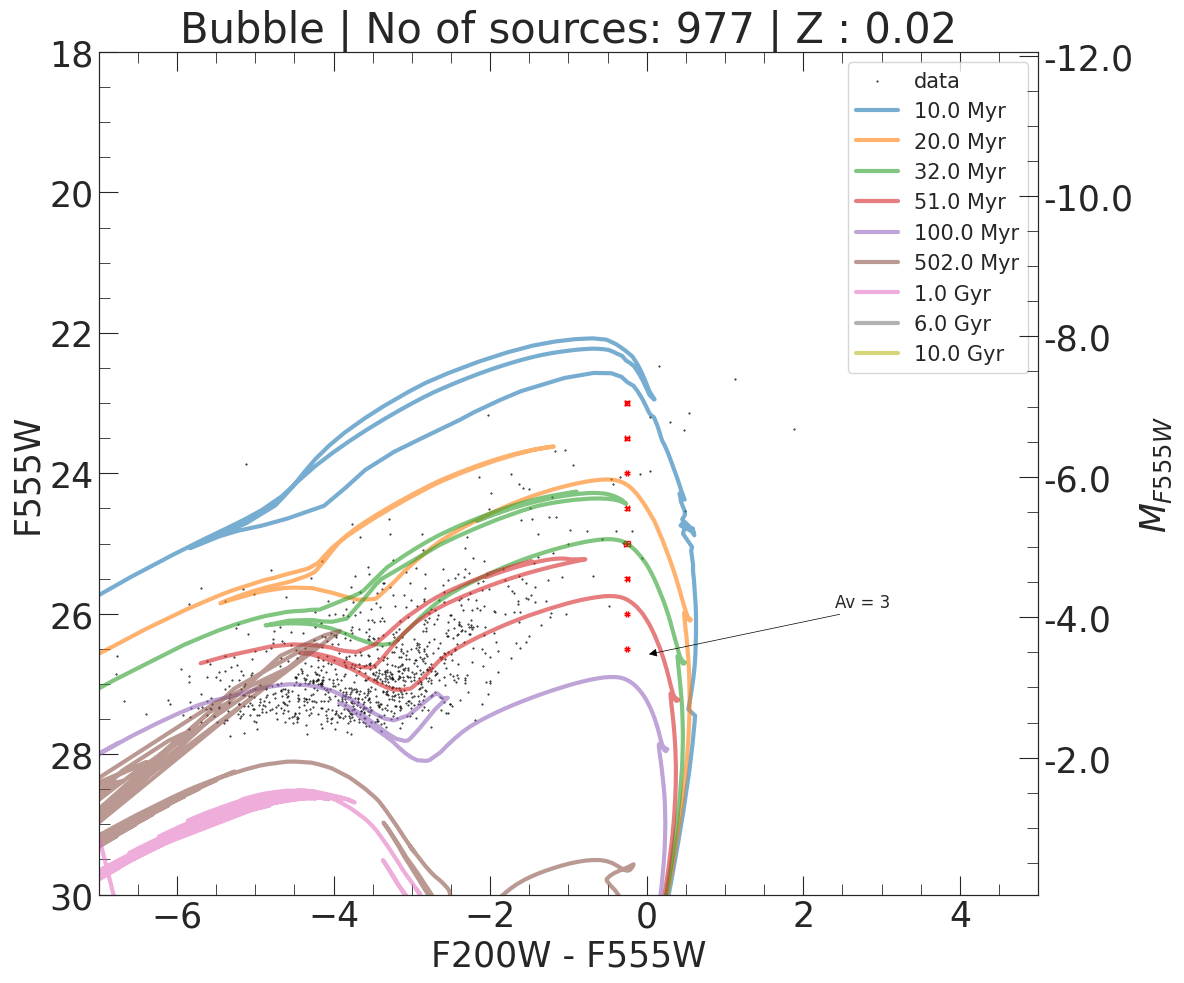

In [250]:
r_in = 0
r_out = 10

fig,ax = gen_CMD('f200w', 'f555w', name='f115w_f150w_f200w_f435w_f555w_f814w',
                 cmd=df_cmd_hst_jwst, r=None, ra_col='ra_1_1', dec_col='dec_1_1',
                 Av_=3, Av_x=2.5, Av_y=26, xlims=[-7,5], ylims=[18,30],
                 out_dir='PHOT_OUTPUT_r25',gen_kde=False, label=9, met=0.02,
                 r_in=r_in, r_out=r_out,
                regions=['bubble'])

## **SED**

In [ ]:
df_sed_bub = Table.read("../data/f275_f336w_f435w_f336w_f115w_f150w_f200w_bub.fits")
df_sed_bkg = Table.read("../data/f275_f336w_f435w_f336w_f115w_f150w_f200w_bkg.fits")

In [ ]:
len(df_sed_bub), len(df_sed_bkg)

In [ ]:
filts = [i.upper() for i in list(Av_dict.keys())]
filts_wav = [2709.7, 3354.5, 4322.0, 5368.0, 8146.9, 11490, 14970, 19680]
Avs = np.array(list(Av_dict.values()))

In [ ]:
m = 21
dm = 0.5

df_filt1 = df_sed_bub[(df_sed_bub['mag_vega_F115W']>= m) 
                      & (df_sed_bub['mag_vega_F115W']<= m + dm)]

df_filt2 = df_sed_bkg[(df_sed_bkg['mag_vega_F115W']>= m) 
                      & (df_sed_bkg['mag_vega_F115W']<= m + dm)]

fig, ax = plt.subplots(figsize=(15,8))

for i in range(len(df_filt1)):

    y = df_filt1[i:i+1]['mag_vega_F275W', 'mag_vega_F336W', 'mag_vega_F435W', 'mag_vega_F555W', 'mag_vega_F814W',
                'mag_vega_F115W', 'mag_vega_F150W', 'mag_vega_F200W'].to_pandas().values[0]

    ax.plot(filts_wav,y,'-ob')
 

for i in range(len(df_filt2)):

    y = df_filt2[i:i+1]['mag_vega_F275W', 'mag_vega_F336W', 'mag_vega_F435W', 'mag_vega_F555W', 'mag_vega_F814W',
                'mag_vega_F115W', 'mag_vega_F150W', 'mag_vega_F200W'].to_pandas().values[0]

    #ax.plot(filts_wav,y,'-or')
    
ax.xaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=10,direction="in", bottom=True, top=True,left=True, right=True)
ax.tick_params(which='minor', length=4);
ax.set_xticks(filts_wav, labels=filts, rotation=45, fontsize = 15)
ax.invert_yaxis();

## **CMD gradient**

In [ ]:
rs = [0,5/0.031]

area = np.pi*(rs[-1]**2 - rs[-2]**2)

while 1:
    r = np.sqrt(area/np.pi + rs[-1]**2)
    if r < 797/2:
        rs.append(r)
    else:
        break
    
rs = np.array(rs)

In [ ]:
rs

In [ ]:
rs[1:]**2 - rs[:-1]**2

In [ ]:
x_cen = 797/2
y_cen = 797/2

In [ ]:
plt.figure(figsize=(7, 10))

ax1 = plt.subplot(1, 1, 1,projection=cutout_n.wcs)

ax1.set_title(filt_n, fontdict=font2)
norm = simple_norm(cutout_n.data, 'sqrt',percent=99.)

img = ax1.imshow(cutout_n.data, norm = norm, cmap='gray')

levels = [13.2,15]

smooth_data = gaussian_filter(cutout_m.data, 2)
cmap = ListedColormap(['yellow','cyan'])
ax1.contour(smooth_data, levels=levels, cmap=cmap, transform=ax1.get_transform(cutout_m.wcs))
#ax1.grid(color='red')


for r in rs:
    circle = Circle((x_cen, y_cen), r, fill=False,  color='black')
    ax1.add_patch(circle)
 
circle = Circle((x_cen, y_cen), 200, fill=False,  color='red')
ax1.add_patch(circle)

circle = Circle((x_cen, y_cen), 282.843, fill=False,  color='red')
ax1.add_patch(circle)

circle = Circle((x_cen, y_cen), rs.max(), fill=False,  color='red')
ax1.add_patch(circle)
    
cb = plt.colorbar(img, orientation='horizontal', anchor = (0.5, 1.1))
cb.set_label(f"{imh_m['BUNIT']}")

In [ ]:
mag_err_lim = 0.1

In [ ]:
age_lin = []
for i in ages_:
    if i > 6  and i <9:
        i-=6
        age_lin.append(f'{np.round(10**i,2)} Myr')
    elif i >= 9:
        i-=9
        age_lin.append(f'{np.round(10**i,2)} Gyr')   

In [ ]:
for i in range(len(rs)-1):
    fig,ax = gen_CMD('f115w', 'f150w', r_in=rs[i],r_out=rs[i+1],
                     cmd=None, flag=111, gen_kde=False, add_ref=True,
                     x_cen=797/2, y_cen=797/2, out_dir='PHOT_OUTPUT_r25')
    fig.suptitle(f"R = {np.round(rs[i],1)}-{np.round(rs[i+1],1)}", fontsize=20)
    plt.show()

## **Simulate Stars using PISTA**

In [ ]:
region, filt_n

In [ ]:
filt_n = 'F435W'

In [ ]:
if not os.path.exists(f"../PHOT_OUTPUT_m50/{region}/{filt_n}"):
    os.mkdir(f"../PHOT_OUTPUT_m50/{region}/{filt_n}")

In [ ]:
hdu = fits.open(f"../PHOT_OUTPUT_AUTO/{region}/{filt_n}/data_conv.fits")[1]

In [ ]:
data_source = hdu.data
pixel_scale = hdu.header['CDELT1']*3600

In [ ]:
norm = simple_norm(data_source, 'sqrt', percent=99.)
plt.imshow(data_source, cmap='jet', norm=norm)

In [ ]:
phot_table = Table.read(f"../PHOT_OUTPUT_AUTO/{region}/{filt_n}/{filt_n}_photometry_filt.fits")

In [ ]:
psf = np.median(fits.open(f'../data/PSF/epsf/{filt_n}/snap_test_psf.fits')[0].data, axis=(1,0))
psf = psf.reshape(51,5,51,5).sum(axis=(1,3))
#psf = np.where(psf>=0,psf,0)
#psf -= psf.min()
psf /= psf.sum()

In [ ]:
hdu = fits.PrimaryHDU(psf)
hdul = fits.HDUList([hdu])
hdul.writeto('psf.fits', overwrite=True)

In [ ]:
data = psf
norm = simple_norm(data, 'log', percent=99.99, log_a=100)
img = plt.imshow(data, cmap='jet', norm=norm)
plt.colorbar(img)

In [ ]:
tel_params ={
            'aperture'       : 650,
            'pixel_scale'    : pixel_scale,
            'psf_file'       : f'psf.fits',
            'response_funcs' :  [ f'{data_path}/INSIST/UV/Coating.dat,5,100',   # 6 mirrors
                                ],
             'coeffs'        : 0.5 ,
             'theta'         : 0
            }

In [ ]:
df = phot_table[ (phot_table['SNR']<20) ][['ra', 'dec',f'mag_vega_{filt_n}', 'flux','flag_phot']].to_pandas()

In [ ]:
df = df[df['flag_phot']==1]

In [ ]:
zero_flux = (df['flux']/10**(-0.4*df[f'mag_vega_{filt_n}'])).mean()

In [ ]:
zp = 2.5*np.log10(zero_flux)

In [ ]:
zero_flux = 10**(0.4*(zp+0.5))

In [ ]:
df = df.rename(columns = {f'mag_vega_{filt_n}': 'mag'})

In [ ]:
sim = pt.Imager(df=df, tel_params=tel_params, exp_time=2000,
               n_x=data_source.shape[0], n_y=data_source.shape[1])

In [ ]:
det_params = {'shot_noise' :  'Poisson',
              'qe_response': [],
              'qe_mean'    : 1,
              'G1'         :  1,
              'bias'       : 10,
              'PRNU_frac'  :  0.25/100,
              'DCNU'       :  0.1/100,
              'RN'         :  3,
              'T'          :  218,
              'DN'         :  0.01/100
              }

In [ ]:
(sim.n_x_sim - sim.n_x)/2, sim.n_x_sim - (sim.n_x_sim - sim.n_x)/2

In [ ]:
sim.shot_noise=False

In [ ]:
sim(det_params=det_params)

In [ ]:
sim.digital.min()

In [ ]:
sim.show_image()

In [ ]:
x = np.random.uniform(100.0,sim.n_x_sim -100,3600)
y = np.random.uniform(100.0,sim.n_y_sim -100,3600)

mag = np.array(list(np.linspace(20,32,60))*60)
df_add  = pd.DataFrame(zip(x,y,mag), columns = ['x','y','mag'])

In [ ]:
sim.shot_noise = False

In [ ]:
out_img = sim.add_stars(data_source, zero_flux, df_add)

In [ ]:
norm = simple_norm(out_img, 'sqrt', percent=99.)
plt.imshow(out_img, cmap='jet', norm=norm)

In [ ]:
hdu = fits.open(f"../PHOT_OUTPUT_EPSF/{region}/{filt_n}/data_conv.fits")

In [ ]:
hdu[1].data = out_img
wcs = WCS(hdu[1].header)

In [ ]:
coords = np.array(wcs.array_index_to_world_values(y-49,x-49))

In [ ]:
df_add['x'] = x - 49
df_add['y'] = y - 49

In [ ]:
df_add['ra'] = coords[0,:]
df_add['dec'] = coords[1,:]

In [ ]:
df_add.to_csv(f"../PHOT_OUTPUT_m50/{region}/{filt_n}/add_stars.csv", index=None)

In [ ]:
hdu.writeto(f"../PHOT_OUTPUT_m50/{region}/{filt_n}/data_conv.fits", 
            overwrite=True)

## **Fitting Pritchet Function**

In [ ]:
@models.custom_model
def pritchet(m,alpha=0.5,m_50=30):
    return 0.5*(1 - alpha*(m - m_50)/np.sqrt(1 + alpha**2*(m-m_50)**2))

In [ ]:
df_match = pd.read_csv(f"../PHOT_OUTPUT_m50/{region}/{filt_n}/matched.csv")

In [ ]:
x = df_match['mag']
y = df_match[f'mag_vega_{filt_n}'] 
yerr = df_match['mag_err']

plt.figure(figsize=(5,5))
plt.errorbar(x, y, yerr, fmt='o', color = 'black', markersize=1, capsize=2)
plt.xlabel('Mag in')
plt.ylabel('Mag out')
plt.plot([25,30],[25,30],'--r')

In [ ]:
df_match = df_match[df_match['flag_phot']==1]
df_match = df_match[abs(df_match['mag'] - df_match[f'mag_vega_{filt_n}'])<2]

In [ ]:
x = df_match['mag']
y = df_match[f'mag_vega_{filt_n}']
yerr = df_match['mag_err']

plt.figure(figsize=(5,5))
plt.errorbar(x, y, yerr, fmt='o', color = 'black', markersize=1, capsize=2)
plt.plot([25,30],[25,30],'--r')

In [ ]:
x = np.array(df_match.groupby('mag').count().index)
y = np.array(df_match.groupby('mag').count()['x_1']/60)

y = y[np.where((x>22)&(x<30))[0]]
x = x[np.where((x>22)&(x<30))[0]]
init = pritchet()
fit = fitting.LevMarLSQFitter()
offset = y.max()
model = fit(init, x, y/offset)

fig, ax = plt.subplots(figsize=(9,7))
ax.scatter(x,y)

ax.plot(x, model(x)*offset, '--r')
ax.set_xlabel('mags')
ax.set_ylabel(r'$N_{out}/N_{in}$')
ax.set_title(f"{region} | {filt_n} | "+ r"$\alpha =$" + f" {np.round(model.alpha.value,2)}" + r" | $m_{50}=$" + f"{np.round(model.m_50.value,2)}")

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True,
               bottom = True, left = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")
ax.set_ylim(0,1)

bkg2, F115W 25.59

In [ ]:
float(np.array(1))

In [ ]:
y